In [1]:
import sys
import os
import gc
import glob
import h5py

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")

import paper_plot as pp

plot = pp.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
from scipy.interpolate import griddata

import ROOT
from ROOT import TLorentzVector, TVector3

import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [2]:
def load_particles_from_h5(filename="/root/data/mc20_truth.h5"):
    result = {}

    with h5py.File(filename, "r") as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}

            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]

            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value

            result[group_name] = group_data

    return result

In [3]:
# main algorithm

def cglmp(z_xp, z_xn, z_yp, z_yn):
    """
    This is a function to calculate Bij (CGLMP values).
    :param z_xp: Angle (xi) between positive lepton and x-axis.
    :param z_xn: Angle (xi) between negative lepton and x-axis.
    :param z_yp: Angle (xi) between positive lepton and y-axis.
    :param z_xn: Angle (xi) between negative lepton and y-axis.
    """
    # count expectation value, use (27) in Alan's paper
    tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
    tr_b = (
        25 * (np.square(z_xp) - np.square(z_yp)) * (np.square(z_xn) - np.square(z_yn))
    )
    tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
    tr = tr_a + tr_b + tr_c

    return tr


def main_alg(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 5.1 Calculate GGM
    # GGM
    lp_pt = np.sqrt(
        np.square(WpLp_k.X()) + np.square(WpLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    ln_pt = np.sqrt(
        np.square(WnLp_k.X()) + np.square(WnLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    lp_phi = np.arctan2(WpLp_k.Y(), WpLp_k.X())  # phi = arctan(Py/Px)
    ln_phi = np.arctan2(WnLp_k.Y(), WnLp_k.X())  # phi = arctan(Py/Px)
    lp_theta = np.arctan(np.divide(lp_pt, WpLp_k.Z()))  # theta = arctan(PT/Pz)
    ln_theta = np.arctan(np.divide(ln_pt, WnLp_k.Z()))  # theta = arctan(PT/Pz)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        np.array([lp_pt, lp_phi, lp_theta]),
        np.array([ln_pt, ln_phi, ln_theta]),
    )

# declare a generator for the resuts

def result_generator(particles):
    bij = np.zeros((particles.shape[0], 3))
    xi_lead = np.zeros((particles.shape[0], 3))
    xi_sublead = np.zeros((particles.shape[0], 3))
    ggm_lead = np.zeros((particles.shape[0], 3))
    ggm_sublead = np.zeros((particles.shape[0], 3))
    result = np.array((particles.shape[0], 3, 5))
    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(main_alg, particles)))
    bij = result[:, 0]
    xi_lead = result[:, 1]
    xi_sublead = result[:, 2]
    ggm_lead = result[:, 3]
    ggm_sublead = result[:, 4]
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_lead[~mask, :],
        xi_sublead[~mask, :],
        ggm_lead[~mask, :],
        ggm_sublead[~mask, :],
        mask,
    )
    
# 8 Wigner P-symbols angular functions

def P1(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.cos(phi)


def P2(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.sin(phi)


def P3(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 0.25 * (c * 4 * np.cos(theta) + 15 * np.cos(2 * theta) + 5)


def P4(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.cos(2 * phi)


def P5(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.sin(2 * phi)


def P6(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.cos(phi)


def P7(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.sin(phi)


def P8(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(1 / 48) * (c * 12 * np.cos(theta) - 15 * np.cos(2 * theta) - 5)

def compute_Wigner(Phi_func: callable, angles: tuple, sign: str) -> np.float64:
    """
    Compute Wigner function for given angles and sign.
    """
    theta_0toPi, phi_0to2Pi = angles
    return Phi_func(theta_0toPi, phi_0to2Pi, sign)


def C_matrix(lp_theta, lp_phi, ln_theta, ln_phi):
    # Adjust angles to the paper requiring
    lp_theta_0toPi = np.where(lp_theta < 0, np.pi + lp_theta, lp_theta)
    ln_theta_0toPi = np.where(ln_theta < 0, np.pi + ln_theta, ln_theta)
    lp_phi_0to2Pi = np.where(lp_phi < 0, 2 * np.pi + lp_phi, lp_phi)
    ln_phi_0to2Pi = np.where(ln_phi < 0, 2 * np.pi + ln_phi, ln_phi)

    PSymb = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
    Phi_functions = [P1, P2, P3, P4, P5, P6, P7, P8]

    # Compute Wigner functions
    WignerPp_results = [
        compute_Wigner(Phi, (lp_theta_0toPi, lp_phi_0to2Pi), "pos")
        for Phi in Phi_functions
    ]
    WignerPn_results = [
        compute_Wigner(Phi, (ln_theta_0toPi, ln_phi_0to2Pi), "neg")
        for Phi in Phi_functions
    ]

    # Construct DataFrames from results
    WignerPp = pd.DataFrame(
        {PSymb[i] + "+": result for i, result in enumerate(WignerPp_results)}
    )
    WignerPn = pd.DataFrame(
        {PSymb[i] + "-": result for i, result in enumerate(WignerPn_results)}
    )

    # Compute C matrix using vectorized operations
    C = np.zeros((9, 9))
    C[0, 1:] = WignerPp.mean() * 0.5
    C[1:, 0] = WignerPn.mean() * 0.5
    for i in range(8):
        for j in range(8):
            C[i + 1, j + 1] = np.mean(WignerPn.iloc[:, i] * WignerPp.iloc[:, j]) * 0.25

    return C, WignerPp, WignerPn, lp_phi_0to2Pi, ln_phi_0to2Pi, lp_theta_0toPi, ln_theta_0toPi, 

In [4]:
# plotting functions

def ggm_plot(C):
    # Input validation
    if not isinstance(C, np.ndarray) or C.shape != (9, 9):
        raise ValueError("Input matrix C must be a 9x9 NumPy array")

    # Create figure
    with plt.style.context('seaborn-v0_8-whitegrid'):
        fig, ax = plt.subplots(figsize=(7, 7), dpi=120)
        
        # Generate meshgrid
        xx, yy = np.meshgrid(np.arange(9), np.arange(9))
        
        # Plot heatmap
        im = ax.pcolormesh(
            xx,
            yy,
            C,
            cmap='RdBu_r',
            vmin=-0.25,
            vmax=0.25,
            shading='nearest',
            edgecolors='none',
        )
        
        # Set aspect ratio and limits
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, 8.5)
        ax.set_ylim(-0.5, 8.5)
        
        # Customize axes
        ax.set_xticks(np.arange(9))
        ax.set_yticks(np.arange(9))
        ax.set_xlabel(r"$W^{\ell_0}$ GM index", fontsize=18)
        ax.set_ylabel(r"$W^{\ell_1}$ GM index", fontsize=18)
        
        # Improve tick appearance
        ax.tick_params(
            axis='both',
            which='both',
            length=0,
            labelsize=16
        )
        
        # Enhanced colorbar matched to y-axis height
        cbar = fig.colorbar(
            im,
            ax=ax,
            orientation='vertical',
            pad=0.02,
            fraction=0.0467,  # Proportion of original axes (tuned for size match)
            aspect=20,       # Aspect ratio (adjusted to match y-axis)
        )
        
        # Customize colorbar ticks
        ticks = np.linspace(-0.25, 0.25, 11)
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])
        cbar.ax.tick_params(labelsize=16)
        
        # Add zero line
        cbar.ax.axhline(y=0, color='grey', linestyle='-', linewidth=1, alpha=0.6)
        
        # Optional grid lines
        ax.grid(True, which='major', linestyle='--', alpha=1)
        
        # Add red frames to specified elements
        highlight_indices = [
            (1, 1), (1, 6), (6, 1), (6, 6), 
            (2, 2), (2, 7), (7, 2), (7, 7), 
            (4, 4), (5, 5)
        ]
        
        for i, j in highlight_indices:
            rect = plt.Rectangle(
                (j - 0.5, i - 0.5),  # (x, y) bottom left corner
                1.0,                  # width
                1.0,                  # height
                fill=False,
                edgecolor='red',
                linewidth=2.5,
                zorder=10             # ensure it's drawn above other elements
            )
            ax.add_patch(rect)
        
        # Optimize layout and display
        plt.tight_layout()
        plt.show()
        plt.close(fig)

def p_plot(theta, phi, p_sym, mode="pos"):
    # Set up the figure with 2x4 subplots (2 rows, 4 columns)
    fig = plt.figure(figsize=(36, 18), dpi=200)
    
    # Adjust subplot parameters to increase spacing between columns
    plt.subplots_adjust(wspace=1.0)
    plt.subplots_adjust(hspace=2.0)

    # List of all p_sym columns to plot
    if mode == "pos":
        columns = ['P1+', 'P2+', 'P3+', 'P4+', 'P5+', 'P6+', 'P7+', 'P8+']
        name = [r'$\Phi^{P_+}_{1}$', r'$\Phi^{P_+}_{2}$', r'$\Phi^{P_+}_{3}$', r'$\Phi^{P_+}_{4}$', r'$\Phi^{P_+}_{5}$', r'$\Phi^{P_+}_{6}$', r'$\Phi^{P_+}_{7}$', r'$\Phi^{P_+}_{8}$']
    elif mode =="neg":
        columns = ['P1-', 'P2-', 'P3-', 'P4-', 'P5-', 'P6-', 'P7-', 'P8-']
        name = [r'$\Phi^{P_-}_{1}$', r'$\Phi^{P_-}_{2}$', r'$\Phi^{P_-}_{3}$', r'$\Phi^{P_-}_{4}$', r'$\Phi^{P_-}_{5}$', r'$\Phi^{P_-}_{6}$', r'$\Phi^{P_-}_{7}$', r'$\Phi^{P_-}_{8}$']
    else:
        raise ValueError("Invalid mode. Choose 'pos' or 'neg'.")

    # Set up the grid for interpolation with fixed ranges
    xi = np.linspace(0, np.pi, 201)  # Fixed theta range from 0 to pi
    yi = np.linspace(0, 2*np.pi, 201)  # Fixed phi range from 0 to 2pi
    X, Y = np.meshgrid(xi, yi)

    # Calculate global min and max for consistent color normalization
    all_Z_values = []
    for col in columns:
        Z = griddata((theta, phi), p_sym[col], (X, Y), method='linear')
        all_Z_values.append(Z)

    # Find global min and max across all plots, ignoring NaN values
    global_min = np.nanmin([np.nanmin(z) for z in all_Z_values])
    global_max = np.nanmax([np.nanmax(z) for z in all_Z_values])
    norm = Normalize(vmin=global_min, vmax=global_max)

    # Create subplots
    for i, col in enumerate(columns):
        # Calculate position (4 columns, 2 rows)
        row = i // 4
        col_pos = i % 4
        
        # Create 3D subplot
        ax = fig.add_subplot(2, 4, i+1, projection='3d')
        
        # Use the pre-calculated Z values
        Z = all_Z_values[i]
        
        # Create the 3D surface plot with consistent color normalization
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', 
                            alpha=0.95, norm=norm)
        
        # Set labels (keep only axis labels)
        ax.set_xlabel(r'$\theta$', fontsize=38, labelpad=20)
        ax.set_ylabel(r'$\phi$', fontsize=38, labelpad=20)
        ax.set_title(name[i], fontsize=38, pad=-50)
        
        # Set fixed axis limits
        ax.set_xlim(np.pi, 0)  # Flipped theta axis (π to 0)
        ax.set_ylim(0, 2*np.pi)  # Fixed phi axis (0 to 2π)
        
        # Set consistent view angle
        ax.view_init(elev=30, azim=30)

    plt.tight_layout()
    plt.show()

In [5]:
mc20_data = load_particles_from_h5()
mc20_data.keys()

dict_keys(['higgs', 'lead_w', 'sublead_w', 'truth_dilep', 'truth_dilep_car', 'truth_lead_lep', 'truth_lead_lep_car', 'truth_lead_nu', 'truth_lead_nu_car', 'truth_sublead_lep', 'truth_sublead_lep_car', 'truth_sublead_nu', 'truth_sublead_nu_car'])

In [6]:
def pt(px, py):
	return np.sqrt(np.square(px) + np.square(py))

def phi(px, py):
	return np.arctan2(py, px)

def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))

In [7]:
# trim length
trim_length = 500_000

# original truth
truth_lead_lep = mc20_data["truth_lead_lep"]
truth_sublead_lep = mc20_data["truth_sublead_lep"]
truth_lead_nu = mc20_data["truth_lead_nu"]
truth_sublead_nu = mc20_data["truth_sublead_nu"]
truth_lead_lep_p4 = mc20_data["truth_lead_lep"]["p4"][0:trim_length]
truth_sublead_lep_p4 = mc20_data["truth_sublead_lep"]["p4"][0:trim_length]
truth_lead_nu_p4 = mc20_data["truth_lead_nu"]["p4"][0:trim_length]
truth_sublead_nu_p4 = mc20_data["truth_sublead_nu"]["p4"][0:trim_length]

truth_lead_lep_pt = mc20_data["truth_lead_lep"]["pt"][0:trim_length]
truth_sublead_lep_pt = mc20_data["truth_sublead_lep"]["pt"][0:trim_length]
truth_dilep_m = mc20_data["truth_dilep"]["m"][0:trim_length]
truth_met_pt = np.sqrt(np.square((truth_lead_nu_p4 + truth_sublead_nu_p4)[...,0:2]).sum(axis=-1))

# CAR truth
truth_lead_lep_car = mc20_data["truth_lead_lep_car"]
truth_sublead_lep_car = mc20_data["truth_sublead_lep_car"]
truth_lead_nu_car = mc20_data["truth_lead_nu_car"]
truth_sublead_nu_car = mc20_data["truth_sublead_nu_car"]
truth_lead_lep_car_p4 = mc20_data["truth_lead_lep_car"]["p4"][0:trim_length]
truth_sublead_lep_car_p4 = mc20_data["truth_sublead_lep_car"]["p4"][0:trim_length]
truth_lead_nu_car_p4 = mc20_data["truth_lead_nu_car"]["p4"][0:trim_length]
truth_sublead_nu_car_p4 = mc20_data["truth_sublead_nu_car"]["p4"][0:trim_length]

truth_lead_lep_car_pt = mc20_data["truth_lead_lep_car"]["pt"][0:trim_length]
truth_sublead_lep_car_pt = mc20_data["truth_sublead_lep_car"]["pt"][0:trim_length]
truth_dilep_m_car = mc20_data["truth_dilep_car"]["m"][0:trim_length]
truth_met_pt_car = np.sqrt(np.square((truth_lead_nu_car_p4 + truth_sublead_nu_car_p4)[...,0:2]).sum(axis=-1))


# W bosons
w_lead_p4 = mc20_data["lead_w"]["p4"][0:trim_length]
w_sublead_p4 = mc20_data["sublead_w"]["p4"][0:trim_length]

In [8]:
# geometry
def get_cut(data, 
            eta_lep_cut=False, eta_el_cut=False, 
            pt_lead_cut=False, pt_sublead_cut=False, 
            m_ll_cut=False, pt_miss_cut=False, 
            fair=False, show=False):
    
    cuts = []
    eta_mu, eta_el, pt_lead, pt_sublead, m_ll, pt_miss = data
    
    # fair cuts
    if fair is True:
        # eta
        cuts.append((np.abs(eta_mu) < 5) & (np.abs(eta_el) < 5))
        # cuts.append(np.abs(eta_el) < 5)
        # pt
        cuts.append(pt_lead > 15)
        cuts.append(pt_sublead > 5)
        if show:
            cut_evt = len(eta_mu) - 1*((np.abs(eta_mu) < 5) & (np.abs(eta_el) < 5) & (pt_lead > 15) & (pt_sublead > 5)).sum()
            print("fair cuts:", cut_evt)
    # Geometry cuts
    if eta_lep_cut is True:
        cuts.append((np.abs(eta_mu) < 2.5) & (np.abs(eta_el) < 2.5))
        # cuts.append(np.abs(eta_el) < 2.5)
        if show:
            cut_evt = len(eta_mu) - 1*((np.abs(eta_mu) < 2.5) & (np.abs(eta_el) < 2.5)).sum()
            print("eta_lep cuts:", cut_evt)
    
    if eta_el_cut is True:
        cuts.append((np.abs(eta_el) < 1.37) | (np.abs(eta_el) > 1.52))
        if show:
            cut_evt = len(eta_el) - 1*((np.abs(eta_el) < 1.37) | (np.abs(eta_el) > 1.52)).sum()
            print("eta_el cuts:", cut_evt)
    
    # Preselections - applied individually when parameters are provided
    if pt_lead_cut is True:
        cuts.append(pt_lead > 22)
        if show:
            cut_evt = len(pt_lead) - 1*(pt_lead > 22).sum()
            print("pt_lead cuts:", cut_evt)
        
    if pt_sublead_cut is True:
        cuts.append(pt_sublead > 15)
        if show:
            cut_evt = len(pt_sublead) - 1*(pt_sublead > 15).sum()
            print("pt_sublead cuts:", cut_evt)
        
    if m_ll_cut is True:
        cuts.append(m_ll > 10)
        if show:
            cut_evt = len(m_ll) - 1*(m_ll > 10).sum()
            print("m_ll cuts:", cut_evt)
        
    if pt_miss_cut is True:
        cuts.append(pt_miss > 20)
        if show:
            cut_evt = len(pt_miss) - 1*(pt_miss > 20).sum()
            print("pt_miss cuts:", cut_evt)
    
    # Combine all cuts with logical AND
    if cuts:
        final_cut = cuts[0]
        if show:
            print(f"Remaining ratio: {(100*final_cut).sum() / len(final_cut):.2f}%")
            print(f"Difference: {len(final_cut) - 1*final_cut.sum()} events")
        for cut in cuts[1:]:
            final_cut = final_cut & cut
            if show:
                print(f"Remaining ratio: {(100*final_cut).sum() / len(final_cut):.2f}%")
        return final_cut
    else:
        return  w_lead_p4[:, 0][:trim_length] > w_lead_p4[:, 0][:trim_length].min()-100 # No cuts applied

In [9]:
lead_el_mask = np.abs(truth_lead_lep["pdgId"][0:trim_length]) == 11
lead_mu_mask = np.abs(truth_lead_lep["pdgId"][0:trim_length]) == 13
el_eta = np.where(lead_el_mask, truth_lead_lep["eta"][0:trim_length], truth_sublead_lep["eta"][0:trim_length])
mu_eta = np.where(lead_mu_mask, truth_lead_lep["eta"][0:trim_length], truth_sublead_lep["eta"][0:trim_length])

lead_el_mask_car = np.abs(truth_lead_lep_car["pdgId"][0:trim_length]) == 11
lead_mu_mask_car = np.abs(truth_lead_lep_car["pdgId"][0:trim_length]) == 13
el_eta_car = np.where(lead_el_mask_car, truth_lead_lep_car["eta"][0:trim_length], truth_sublead_lep_car["eta"][0:trim_length])
mu_eta_car = np.where(lead_mu_mask_car, truth_lead_lep_car["eta"][0:trim_length], truth_sublead_lep_car["eta"][0:trim_length])

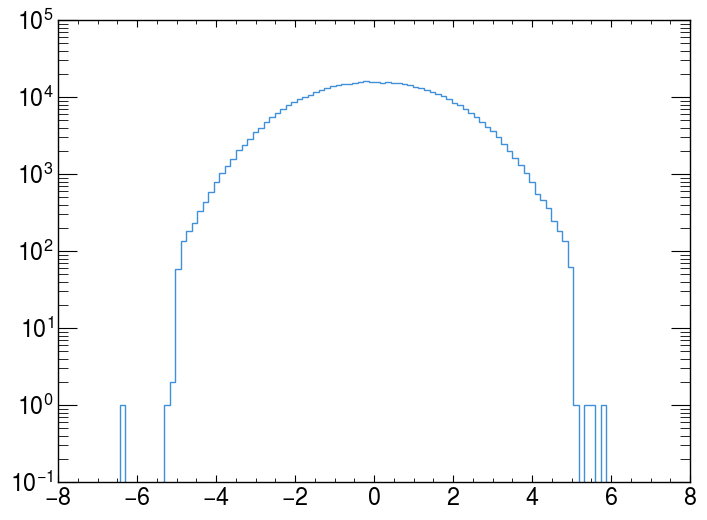

In [10]:
plt.hist(mu_eta, bins=np.linspace(-7, 7, 101), histtype="step", label="lead_lep")
plt.semilogy()
plt.show()

fair cuts: 39039
eta_lep cuts: 115277
eta_el cuts: 25192
pt_lead cuts: 56866
pt_sublead cuts: 217281
m_ll cuts: 10971
pt_miss cuts: 74108
Remaining ratio: 99.57%
Difference: 2160 events
Remaining ratio: 96.87%
Remaining ratio: 92.19%
Remaining ratio: 72.99%
Remaining ratio: 68.80%
Remaining ratio: 63.85%
Remaining ratio: 42.09%
Remaining ratio: 41.32%
Remaining ratio: 35.36%
22.000359


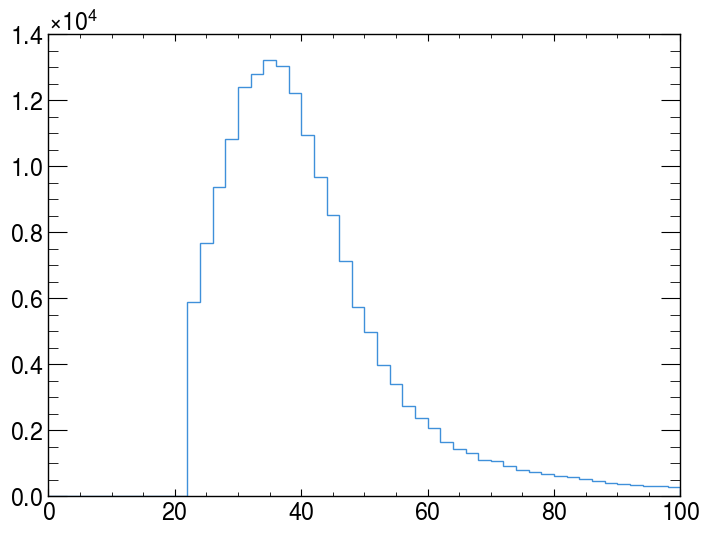

In [11]:
data_test = [mu_eta_car, el_eta_car, truth_lead_lep_car["pt"][0:trim_length], truth_sublead_lep_car["pt"][0:trim_length], truth_dilep_m_car[0:trim_length], truth_met_pt_car[0:trim_length]]
test_cut = get_cut(data_test, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True, pt_sublead_cut=True, m_ll_cut=True, pt_miss_cut=True, fair=True, show=True)
plt.hist(truth_lead_lep_car["pt"][:trim_length][test_cut], bins=np.linspace(0,100,51), histtype="step", label="lead lepton", density=False)
print(truth_lead_lep_car["pt"][:trim_length][test_cut].min())
# plt.vlines(1.52, 0, 1e5, color="r", label="Lead Lep")
# plt.vlines(1.37, 0, 1e5, color="r", label="Lead Lep")
# plt.ylim(0, 0.8*1e4)
plt.show()

(array([2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.4600e+02,
        3.1100e+02, 5.6400e+02, 8.5200e+02, 1.4390e+03, 2.1620e+03,
        3.1560e+03, 4.5920e+03, 6.1340e+03, 7.9110e+03, 9.9960e+03,
        1.2206e+04, 1.4597e+04, 1.7031e+04, 1.8965e+04, 2.1495e+04,
        2.3065e+04, 2.5107e+04, 2.5901e+04, 2.6804e+04, 2.7421e+04,
        2.7544e+04, 2.6736e+04, 2.5690e+04, 2.4813e+04, 2.3220e+04,
        2.1423e+04, 1.9466e+04, 1.6946e+04, 1.4590e+04, 1.2158e+04,
        1.0194e+04, 7.8810e+03, 6.2090e+03, 4.5640e+03, 3.2460e+03,
        2.1260e+03, 1.4760e+03, 8.9500e+02, 5.3600e+02, 2.8900e+02,
        1.2700e+02, 3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00]),
 array([-6.  , -5.76, -5.52, -5.28, -5.04, -4.8 , -4.56, -4.32, -4.08,
        -3.84, -3.6 , -3.36, -3.12, -2.88, -2.64, -2.4 , -2.16, -1.92,
        -1.68, -1.44, -1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,
         0.48,  0.72,  0.96,  1.2 ,  1.44,  1.68,  1.92,  2.16,  2.4 ,
         2.64,  2.88,  3.12,  3.36

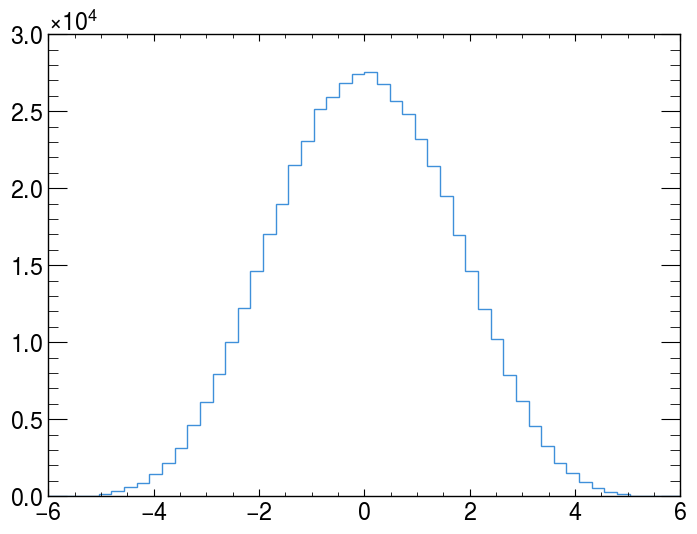

In [12]:
plt.hist(el_eta, bins=np.linspace(-6, 6, 51), histtype="step", label="lead lepton", density=False)

In [13]:
# truth cuts
data_sm = [mu_eta, el_eta, truth_lead_lep["pt"][0:trim_length], truth_sublead_lep["pt"][0:trim_length], truth_dilep_m[0:trim_length], truth_met_pt[0:trim_length]]
cut0 = get_cut(data_sm)
cut_fair = get_cut(data_sm, fair=True)
cut1 = get_cut(data_sm, fair=True, eta_lep_cut=True)
cut2 = get_cut(data_sm, fair=True, eta_lep_cut=True, eta_el_cut=True)
cut3 = get_cut(data_sm, fair=True, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True)
cut4 = get_cut(data_sm, fair=True, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True, pt_sublead_cut=True)
cut5 = get_cut(data_sm, fair=True, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True, pt_sublead_cut=True, m_ll_cut=True)
cut6 = get_cut(data_sm, fair=True, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True, pt_sublead_cut=True, m_ll_cut=True, pt_miss_cut=True, show=True)
truth_cuts = [cut0, cut_fair, cut1, cut2, cut3, cut4, cut5, cut6]
print("")
# CAR cuts
data_sep = [mu_eta_car, el_eta_car, truth_lead_lep_car["pt"][0:trim_length], truth_sublead_lep_car["pt"][0:trim_length], truth_dilep_m_car[0:trim_length], truth_met_pt_car[0:trim_length]]
cut0 = get_cut(data_sep)
cut_fair = get_cut(data_sep, fair=True)
cut1 = get_cut(data_sep, fair=True, eta_lep_cut=True)
cut2 = get_cut(data_sep, fair=True, eta_lep_cut=True, eta_el_cut=True)
cut3 = get_cut(data_sep, fair=True, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True)
cut4 = get_cut(data_sep, fair=True, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True, pt_sublead_cut=True)
cut5 = get_cut(data_sep, fair=True, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True, pt_sublead_cut=True, m_ll_cut=True)
cut6 = get_cut(data_sep, fair=True, eta_lep_cut=True, eta_el_cut=True, pt_lead_cut=True, pt_sublead_cut=True, m_ll_cut=True, pt_miss_cut=True, show=True)
car_cuts = [cut0, cut_fair, cut1, cut2, cut3, cut4, cut5, cut6]

fair cuts: 636
eta_lep cuts: 99254
eta_el cuts: 25460
pt_lead cuts: 44134
pt_sublead cuts: 198216
m_ll cuts: 24993
pt_miss cuts: 48597
Remaining ratio: 99.99%
Difference: 28 events
Remaining ratio: 99.98%
Remaining ratio: 99.87%
Remaining ratio: 80.07%
Remaining ratio: 75.44%
Remaining ratio: 69.60%
Remaining ratio: 45.07%
Remaining ratio: 42.93%
Remaining ratio: 38.74%

fair cuts: 39039
eta_lep cuts: 115277
eta_el cuts: 25192
pt_lead cuts: 56866
pt_sublead cuts: 217281
m_ll cuts: 10971
pt_miss cuts: 74108
Remaining ratio: 99.57%
Difference: 2160 events
Remaining ratio: 96.87%
Remaining ratio: 92.19%
Remaining ratio: 72.99%
Remaining ratio: 68.80%
Remaining ratio: 63.85%
Remaining ratio: 42.09%
Remaining ratio: 41.32%
Remaining ratio: 35.36%


[2.21737392 2.48371846 2.7634321 ] [0.01686435 0.01358824 0.01420309]


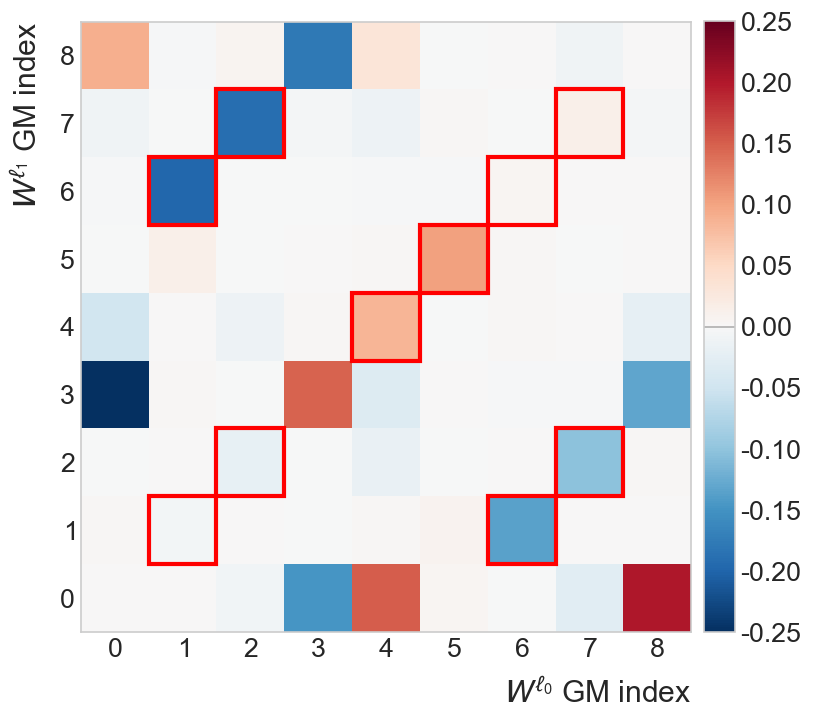

[2.21824045 2.48109536 2.76470152] [0.01687727 0.01359197 0.01421346]


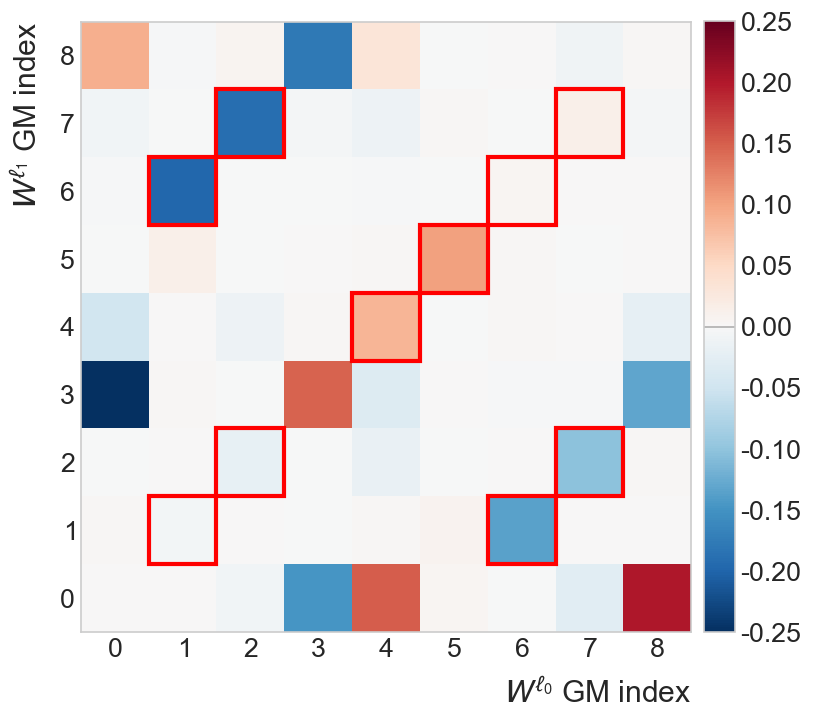

[2.33904944 2.51585921 2.88256495] [0.01879495 0.01504505 0.01609585]


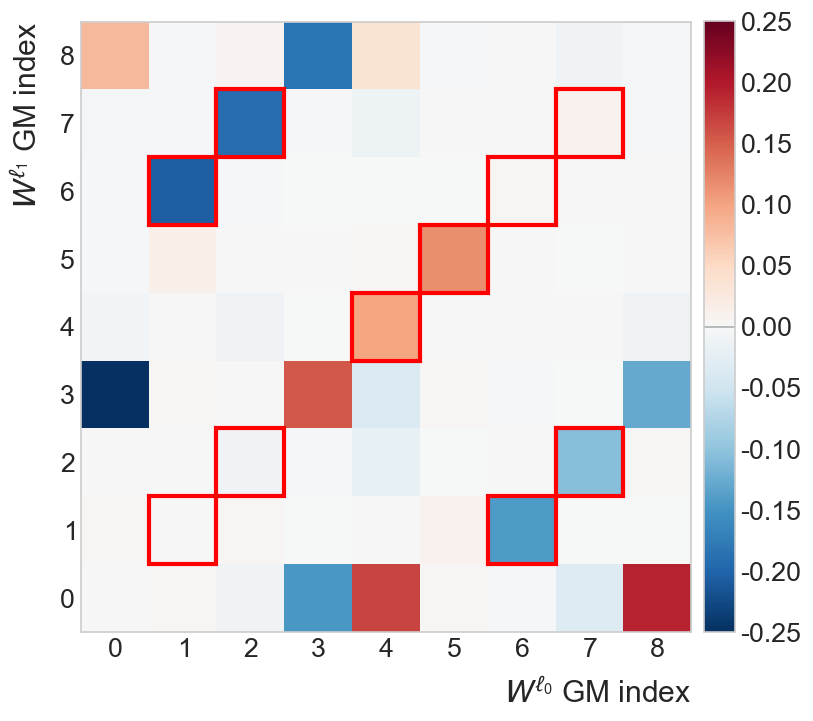

[2.33330977 2.51049721 2.87978699] [0.01936616 0.01549954 0.01656742]


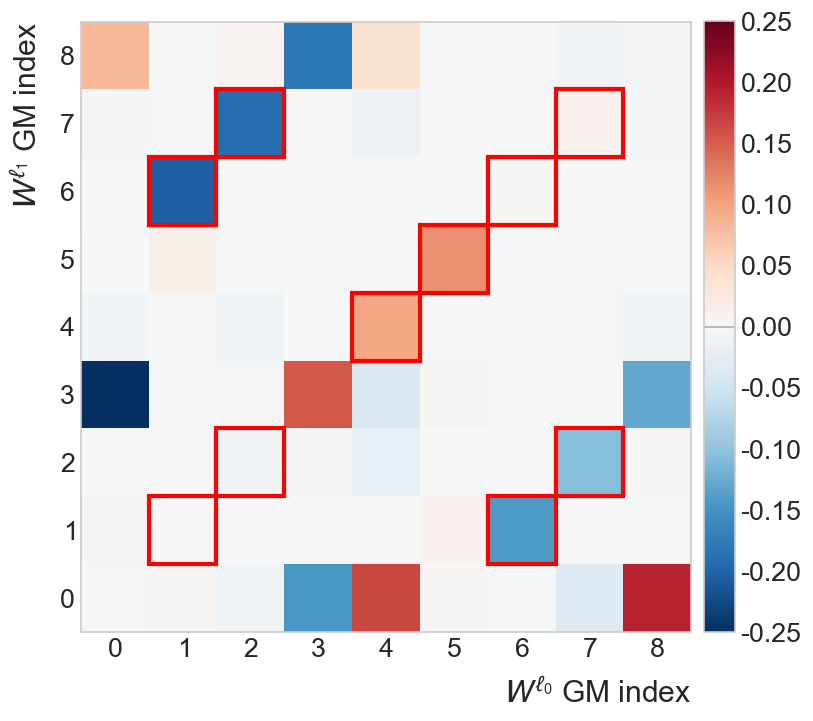

[2.30309279 2.3563854  2.99937964] [0.02017898 0.01583327 0.0174479 ]


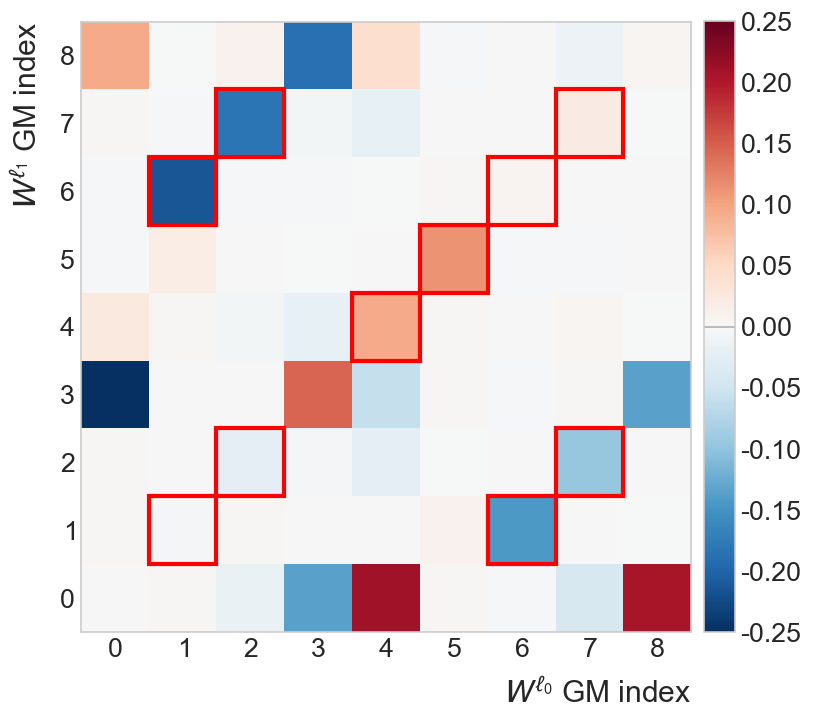

[2.62946175 2.17133136 3.20058521] [0.02539567 0.01899026 0.02222336]


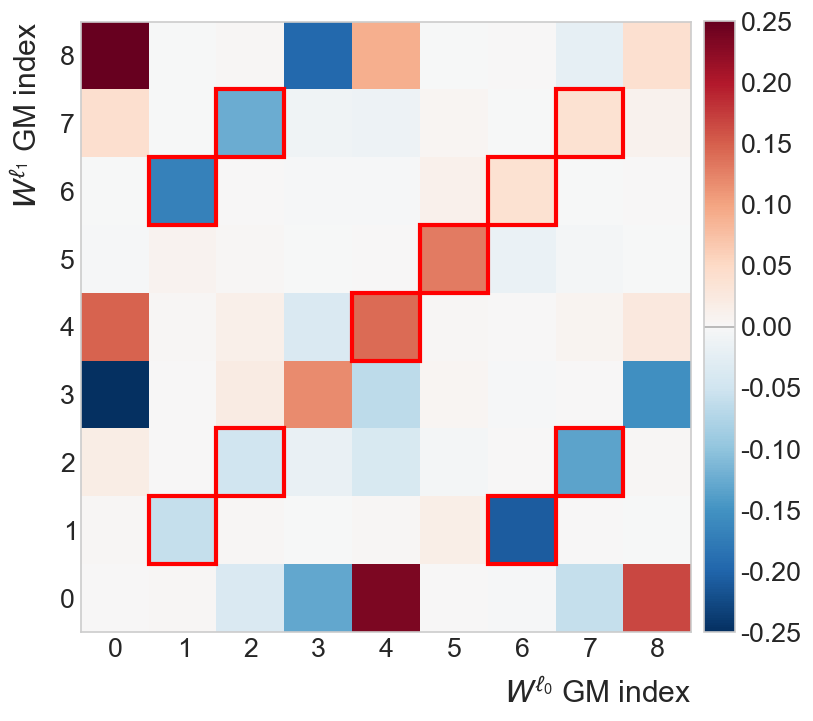

[2.1802219  1.94482579 2.95891789] [0.02599297 0.0191694  0.02259118]


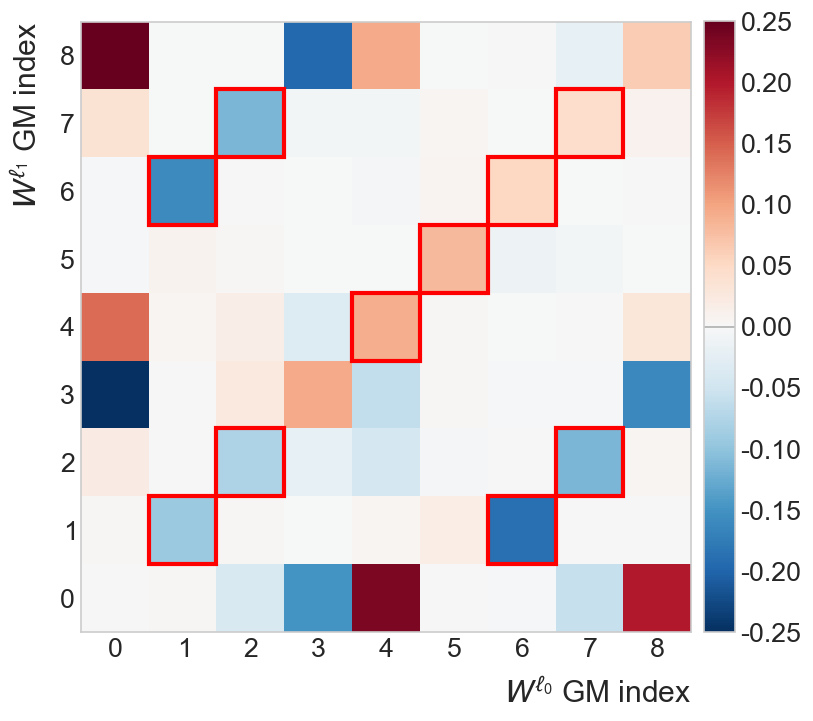

[2.43729139 2.00491312 3.22747966] [0.0272797  0.01968403 0.02432617]


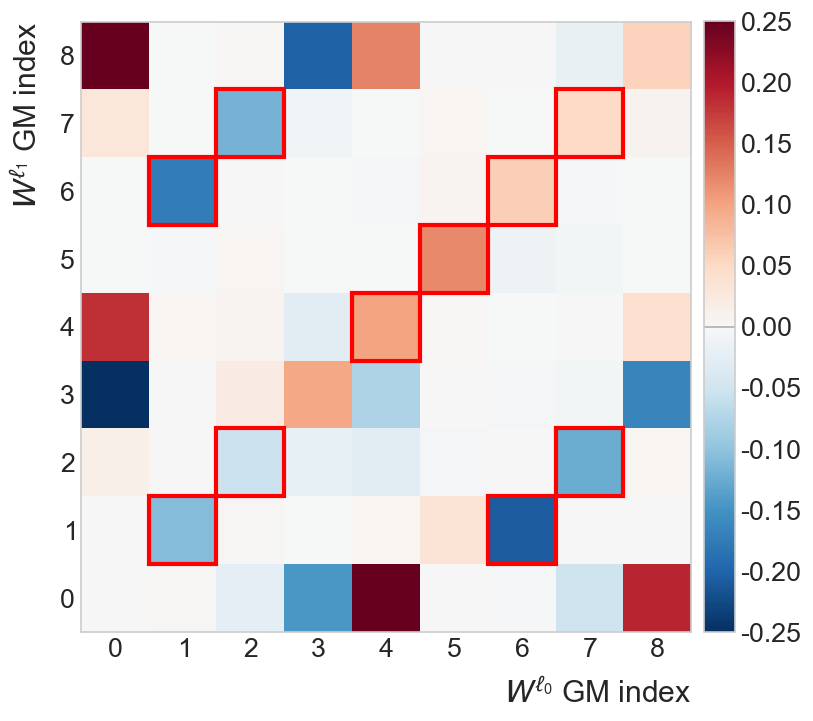

In [14]:
# calculate results
truth_bij_mean = []
truth_bij_sem = []
truth_xi = []
truth_bij_lst = []

for cut in truth_cuts:
    truth_particles = np.concatenate(
        [w_lead_p4[cut], truth_lead_lep_p4[cut], w_sublead_p4[cut], truth_sublead_lep_p4[cut]], axis=1
    )
    truth_bij, truth_xi_pos, truth_xi_neg, truth_ggm_pos, truth_ggm_neg, truth_mask = result_generator(
        truth_particles
    )
    sem = sp.stats.sem(truth_bij, axis=0)
    mean = np.mean(truth_bij, axis=0)
    truth_bij_mean.append(mean)
    truth_bij_sem.append(sem)
    truth_xi.append([truth_xi_pos, truth_xi_neg])
    truth_bij_lst.append(truth_bij)
    print(mean, sem)
    truth_phi_pos, truth_phi_neg = truth_ggm_pos[:, 1], truth_ggm_neg[:, 1]
    truth_theta_pos, truth_theta_neg = truth_ggm_pos[:, 2], truth_ggm_neg[:, 2]
    truth_C, p_pos, p_neg, phi_pos, phi_neg, theta_pos, theta_neg = C_matrix(truth_theta_pos, truth_phi_pos, truth_theta_neg, truth_phi_neg)
    ggm_plot(truth_C)
    del truth_particles, truth_xi_pos, truth_xi_neg, truth_ggm_pos, truth_ggm_neg, truth_mask
    gc.collect()

[0.05870939 1.51470648 1.82869723] [0.0158385  0.01270383 0.01277124]


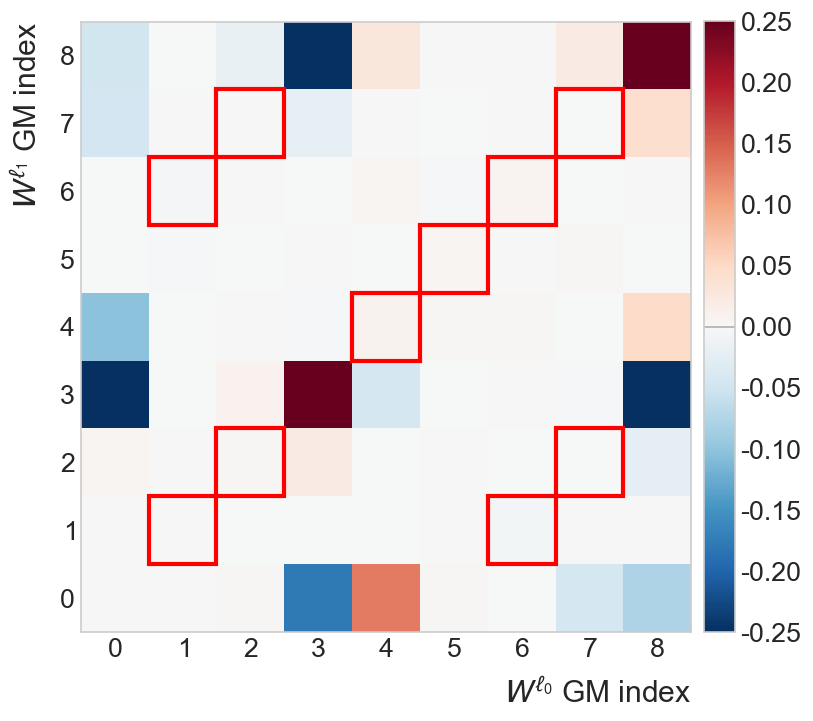

[0.01293649 1.51684132 1.96063805] [0.0166335  0.01288657 0.01345903]


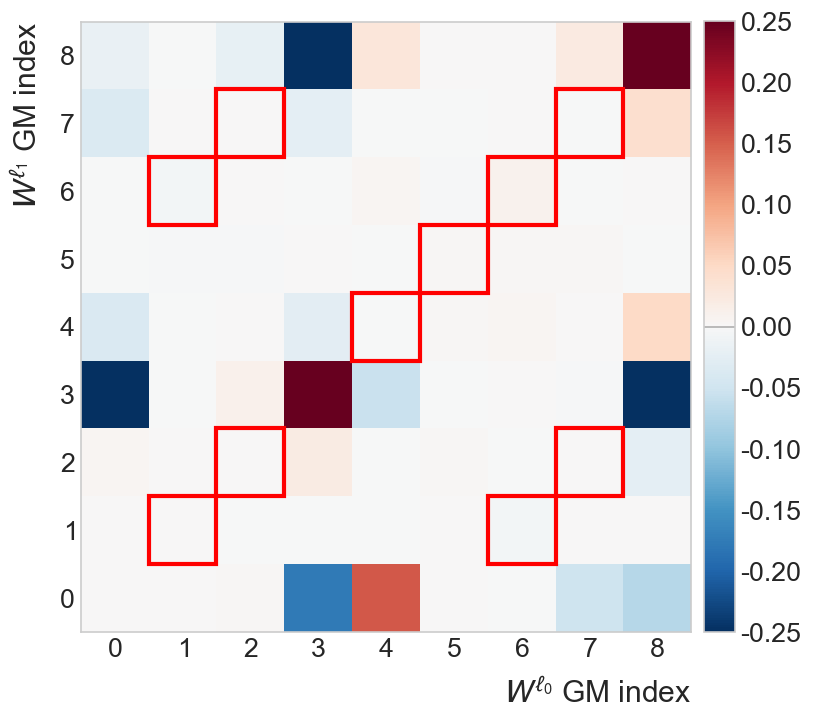

[0.11830219 1.49472945 1.97659152] [0.01877156 0.0143145  0.01533316]


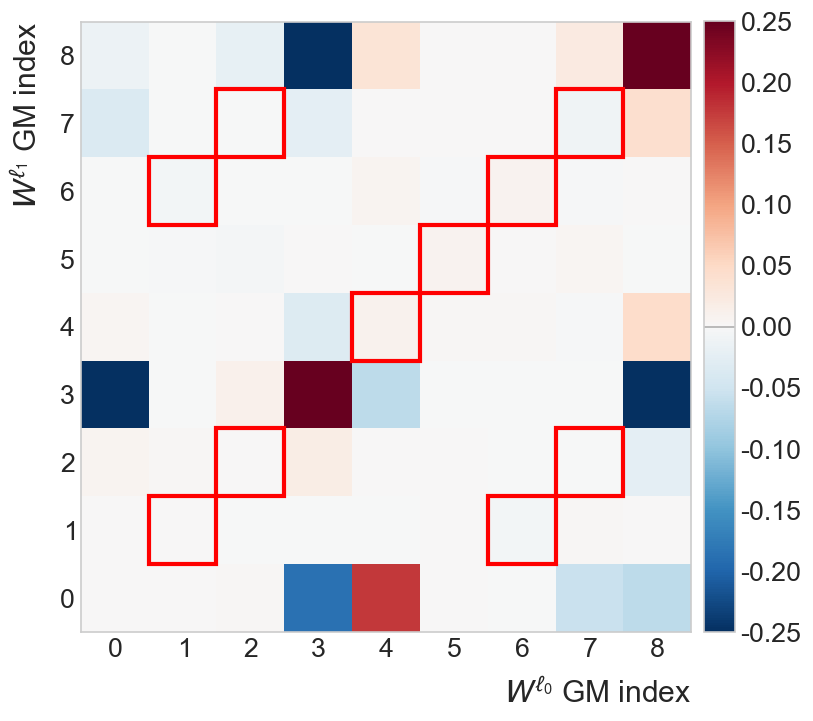

[0.11392008 1.49419946 1.9740802 ] [0.01933358 0.01474108 0.01578737]


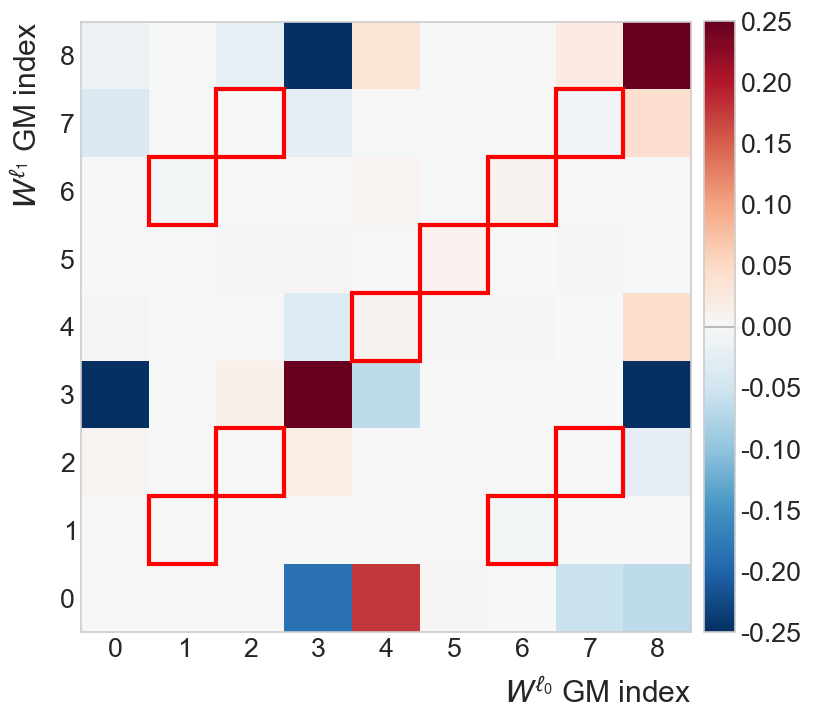

[0.11311978 1.49016003 2.05446083] [0.02017902 0.01497643 0.01656102]


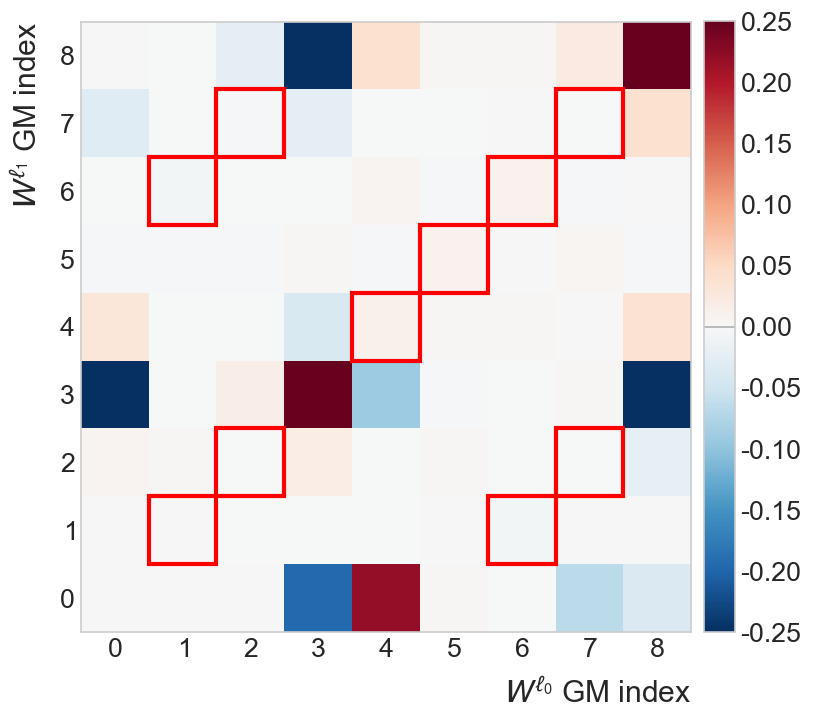

[0.33918882 1.76772702 2.50540745] [0.02475989 0.01809666 0.02113629]


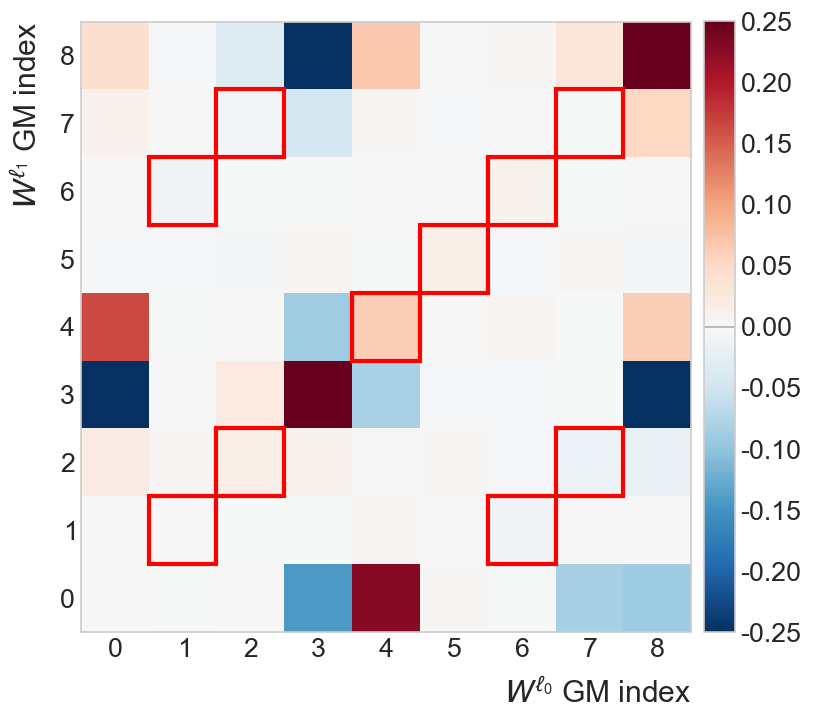

[0.04183755 1.76080909 2.47784465] [0.02466464 0.01826639 0.0213098 ]


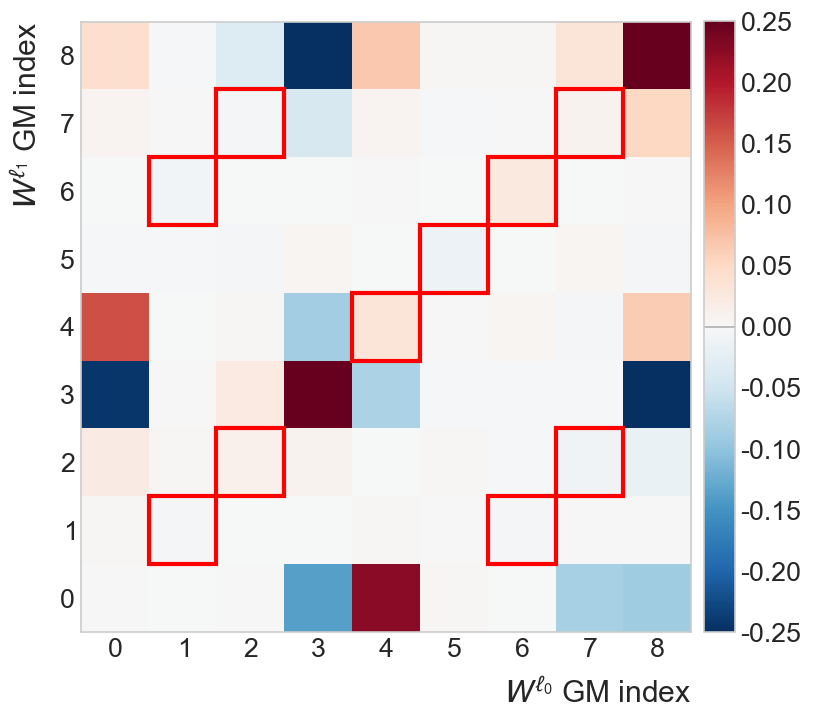

[0.09180078 1.70648856 2.36955286] [0.02691517 0.01942621 0.0235671 ]


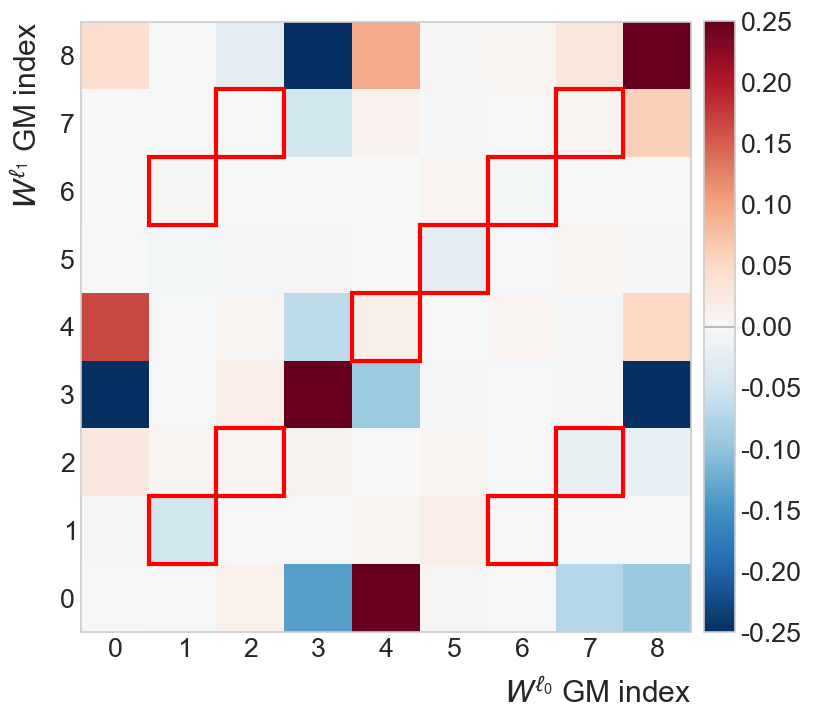

In [15]:
# CAR truth
car_bij_mean = []
car_bij_sem = []
car_xi = []
car_bij_lst = []

for cut in car_cuts:
    car_particles = np.concatenate(
        [w_lead_p4[cut], truth_lead_lep_car_p4[cut], w_sublead_p4[cut], truth_sublead_lep_car_p4[cut]], axis=1
    )
    car_bij, car_xi_pos, car_xi_neg, car_ggm_pos, car_ggm_neg, car_mask = result_generator(
        car_particles
    )
    sem = sp.stats.sem(car_bij, axis=0)
    mean = np.mean(car_bij, axis=0)
    car_bij_mean.append(mean)
    car_bij_sem.append(sem)
    car_xi.append([car_xi_pos, car_xi_neg])
    car_bij_lst.append(car_bij)
    print(mean, sem)
    car_phi_pos, car_phi_neg = car_ggm_pos[:, 1], car_ggm_neg[:, 1]
    car_theta_pos, car_theta_neg = car_ggm_pos[:, 2], car_ggm_neg[:, 2]
    car_C, car_p_pos, car_p_neg, car_phi_pos, car_phi_neg, car_theta_pos, car_theta_neg = C_matrix(car_theta_pos, car_phi_pos, car_theta_neg, car_phi_neg)
    ggm_plot(car_C)
    del car_particles, car_xi_pos, car_xi_neg, car_ggm_pos, car_ggm_neg, car_mask
    gc.collect()

In [16]:
truth_bij_sem = np.array(truth_bij_sem)
car_bij_mean = np.array(car_bij_mean)
car_bij_sem = np.array(car_bij_sem)
truth_bij_mean = np.array(truth_bij_mean)

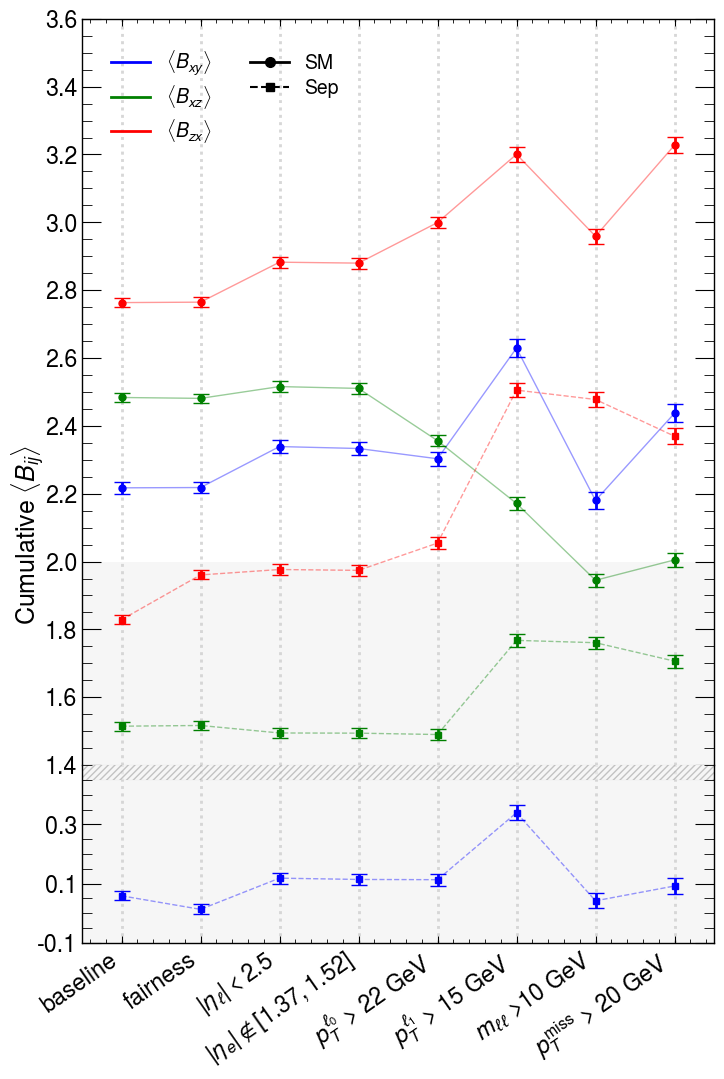

In [17]:
# Set up x positions and labels
x = np.arange(8)
categories = ['baseline', 'fairness', r'$|\eta_{\ell}| < 2.5$', r'$|\eta_{e}| \notin [ 1.37, 1.52]$', r'$p_T^{\ell_0}$ > 22 GeV', r'$p_T^{\ell_1}$ > 15 GeV', r'$m_{\ell\ell}$ >10 GeV', r'$p_T^{\text{miss}}$ > 20 GeV']
components = [r'$\langle {B}_{xy} \rangle$', r'$\langle {B}_{xz} \rangle$', r'$\langle {B}_{zx} \rangle$']
component_colors = ['blue', 'green', 'red']

# Create two subplots with a broken y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12), gridspec_kw={'height_ratios': [4.2, 1]})

# Find global min and max for consistent y-axis scaling
global_min = float('inf')
global_max = float('-inf')

for i in range(3):
    min_val = min(np.min(truth_bij_mean[:, i] - truth_bij_sem[:, i]), 
                  np.min(car_bij_mean[:, i] - car_bij_sem[:, i]))
    max_val = max(np.max(truth_bij_mean[:, i] + truth_bij_sem[:, i]), 
                  np.max(car_bij_mean[:, i] + car_bij_sem[:, i]))
    global_min = min(global_min, min_val)
    global_max = max(global_max, max_val)

y_padding = (global_max - global_min) * 0.1

# Set y-limits for the two subplots
ax1.set_ylim(1.4, global_max + y_padding)
ax2.set_ylim(-0.1, 0.5)

# Add shaded background where y < 2
ax1.axhspan(1.4, 2, facecolor='lightgray', alpha=0.2)
ax2.axhspan(-0.1, 0.5, facecolor='lightgray', alpha=0.2)

# Turn off the default grid for both subplots
ax1.grid(False)
ax2.grid(False)

# Small x offset for each component to avoid overlap
offsets = [0, 0, 0]

# Plot the data on both subplots
for i in range(3):
    # Plot faint connecting lines for Truth with alpha=0.2
    ax1.plot(x + offsets[i], truth_bij_mean[:, i], 
             linestyle='-', linewidth=1, color=component_colors[i], alpha=0.4)
    ax2.plot(x + offsets[i], truth_bij_mean[:, i], 
             linestyle='-', linewidth=1, color=component_colors[i], alpha=0.4)
    
    # Plot markers and error bars for Truth (fully opaque)
    ax1.errorbar(x + offsets[i], truth_bij_mean[:, i], yerr=truth_bij_sem[:, i],
                 fmt='o', capsize=6, elinewidth=2, markersize=5, color=component_colors[i],
                 label=f'Truth {components[i]}')
    ax2.errorbar(x + offsets[i], truth_bij_mean[:, i], yerr=truth_bij_sem[:, i],
                 fmt='o', capsize=6, elinewidth=2, markersize=5, color=component_colors[i])
    
    # Plot faint connecting lines for CAR with alpha=0.4
    ax1.plot(x + offsets[i], car_bij_mean[:, i], 
             linestyle='--', linewidth=1, color=component_colors[i], alpha=0.4)
    ax2.plot(x + offsets[i], car_bij_mean[:, i], 
             linestyle='--', linewidth=1, color=component_colors[i], alpha=0.4)
    
    # Plot markers and error bars for CAR (fully opaque)
    ax1.errorbar(x + offsets[i], car_bij_mean[:, i], yerr=car_bij_sem[:, i],
                 fmt='s', capsize=6, elinewidth=2, markersize=4, color=component_colors[i],
                 label=f'CAR {components[i]}')
    ax2.errorbar(x + offsets[i], car_bij_mean[:, i], yerr=car_bij_sem[:, i],
                 fmt='s', capsize=6, elinewidth=2, markersize=4, color=component_colors[i])
    
    # Add vertical grid lines
    for j in range(len(x)):
        ax1.axvline(x=j, color='lightgray', linestyle=':', alpha=0.5, zorder=0)
        ax2.axvline(x=j, color='lightgray', linestyle=':', alpha=0.5, zorder=0)

# Set titles and labels
fig.text(0.07, 0.5, r'Cumulative $\langle {B}_{ij} \rangle$', va='center', rotation='vertical', fontsize=18)

# Set x-ticks and labels with 35-degree rotation
ax2.set_xticks(x)
ax2.set_xticklabels(categories, rotation=35, ha='right')
ax2.set_xlim(-0.5, len(x) - 0.5)

# Set y-ticks with increments of 0.2
ax2.set_yticks(np.arange(-0.1, 0.5, 0.2))
ax2.set_yticklabels([f"{tick:.1f}" for tick in np.arange(-0.1, 0.5, 0.2)])
upper_bound = np.ceil((global_max + y_padding) / 0.2) * 0.2
ax1.set_yticks(np.arange(1.4, upper_bound + 0.1, 0.2))
ax1.set_yticklabels([f"{tick:.1f}" for tick in np.arange(1.4, upper_bound + 0.1, 0.2)])

# Create a custom legend
component_handles = [plt.Line2D([0], [0], color=component_colors[i], 
                               marker='', linestyle='-', linewidth=2, 
                               markersize=7, label=components[i])
                    for i in range(3)]
method_handles = [
    plt.Line2D([0], [0], color='black', marker='o', linestyle='-', 
              linewidth=2, markersize=7, label='SM'),
    plt.Line2D([0], [0], color='black', marker='s', linestyle='--', 
              linewidth=1.5, markersize=6, label='Sep')
]

# Combine all handles into one legend
all_handles = component_handles + method_handles
ax1.legend(handles=all_handles, loc='upper left', frameon=False, ncol=2)

# Adjust the layout with some space for the break bands
plt.subplots_adjust(hspace=0.00)

# Hide the spines between the subplots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

# Add ///// break bands
# Define the height of the break band in data coordinates
break_height_ax1 = 0.00  # Height in ax1 (upper subplot) data units
break_height_ax2 = 0.05  # Height in ax2 (lower subplot) data units

# Add hatched rectangles for the break bands
ax1.add_patch(mpatches.Rectangle((-0.5, 1.4), len(x), break_height_ax1, 
                                 facecolor='white', hatch='/////', 
                                 edgecolor='grey', linewidth=0.05, zorder=0.0, alpha=0.5))
ax2.add_patch(mpatches.Rectangle((-0.5, 0.5 - break_height_ax2), len(x), break_height_ax2, 
                                 facecolor='white', hatch='/////', 
                                 edgecolor='grey', linewidth=0.05, zorder=0.0, alpha=0.5))

# Save and show the plot
# plt.savefig('combined_bij_components_broken_axis_faint_lines.png', dpi=300)
plt.show()

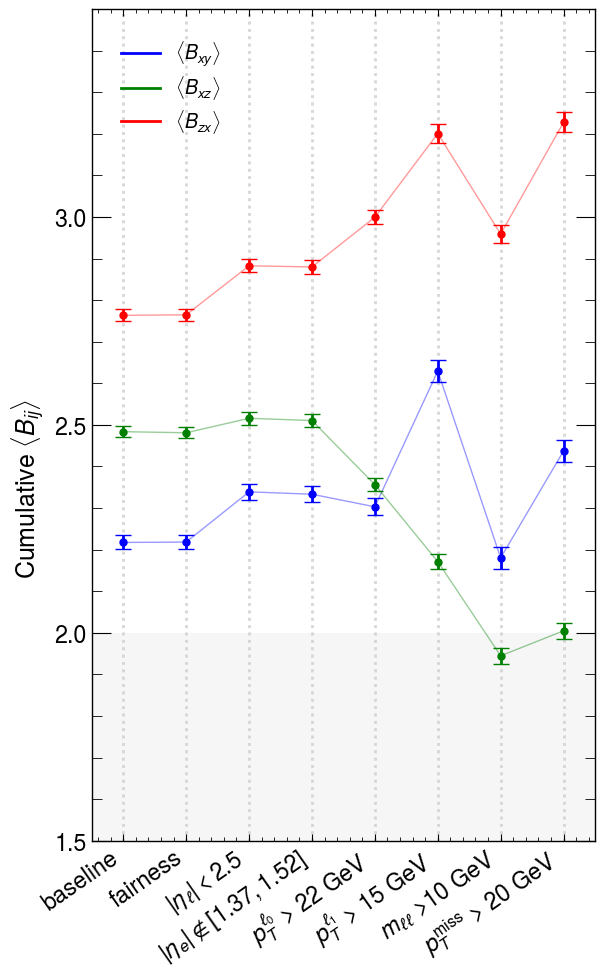

In [27]:
# Set up x positions and labels
x = np.arange(8)
categories = ['baseline', 'fairness', r'$|\eta_{\ell}| < 2.5$', r'$|\eta_{e}| \notin [ 1.37, 1.52]$', 
              r'$p_T^{\ell_0}$ > 22 GeV', r'$p_T^{\ell_1}$ > 15 GeV', r'$m_{\ell\ell}$ >10 GeV', 
              r'$p_T^{\text{miss}}$ > 20 GeV']
components = [r'$\langle {B}_{xy} \rangle$', r'$\langle {B}_{xz} \rangle$', r'$\langle {B}_{zx} \rangle$']
component_colors = ['blue', 'green', 'red']

# Create a single plot with adjusted figure size (no broken y-axis)
fig, ax1 = plt.subplots(figsize=(6, 10))

# Find global min and max for consistent y-axis scaling
global_min = float('inf')
global_max = float('-inf')

for i in range(3):
    min_val = min(np.min(truth_bij_mean[:, i] - truth_bij_sem[:, i]), 
                  np.min(car_bij_mean[:, i] - car_bij_sem[:, i]))
    max_val = max(np.max(truth_bij_mean[:, i] + truth_bij_sem[:, i]), 
                  np.max(car_bij_mean[:, i] + car_bij_sem[:, i]))
    global_min = min(global_min, min_val)
    global_max = max(global_max, max_val)

# Set y-limits for the plot with fixed ranges
ax1.set_ylim(1.5, 3.5)  # Set plot range from 1.5 to 3.5

# Add shaded background
ax1.axhspan(1.5, 2.0, facecolor='lightgray', alpha=0.2)

# Turn off the default grid
ax1.grid(False)

# Small x offset for each component to avoid overlap
offsets = [0, 0, 0]

# Plot the data
for i in range(3):
    # Plot faint connecting lines for Truth with alpha=0.4
    ax1.plot(x + offsets[i], truth_bij_mean[:, i], 
             linestyle='-', linewidth=1, color=component_colors[i], alpha=0.4)
    
    # Plot markers and error bars for Truth (fully opaque)
    ax1.errorbar(x + offsets[i], truth_bij_mean[:, i], yerr=truth_bij_sem[:, i],
                 fmt='o', capsize=6, elinewidth=2, markersize=5, color=component_colors[i],
                 label=f'Truth {components[i]}')
    
    # Add vertical grid lines
    for j in range(len(x)):
        ax1.axvline(x=j, color='lightgray', linestyle=':', alpha=0.5, zorder=0)

# Set titles and labels
fig.text(-0.01, 0.5, r'Cumulative $\langle {B}_{ij} \rangle$', va='center', rotation='vertical', fontsize=18)

# Set x-ticks and labels with 35-degree rotation
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=35, ha='right')
ax1.set_xlim(-0.5, len(x) - 0.5)

# Set y-ticks with increments of 0.5
ax1.set_yticks(np.arange(1.5, 3.5, 0.5))
ax1.set_yticklabels([f"{tick:.1f}" for tick in np.arange(1.5, 3.5, 0.5)])

# Create a custom legend
component_handles = [plt.Line2D([0], [0], color=component_colors[i], 
                               marker='', linestyle='-', linewidth=2, 
                               markersize=7, label=components[i])
                    for i in range(3)]

# Combine all handles into one legend
all_handles = component_handles 
ax1.legend(handles=all_handles, loc='upper left', frameon=False, ncol=1)

plt.tight_layout()
plt.show()

CAR (ground truth) vs SM (ground truth)


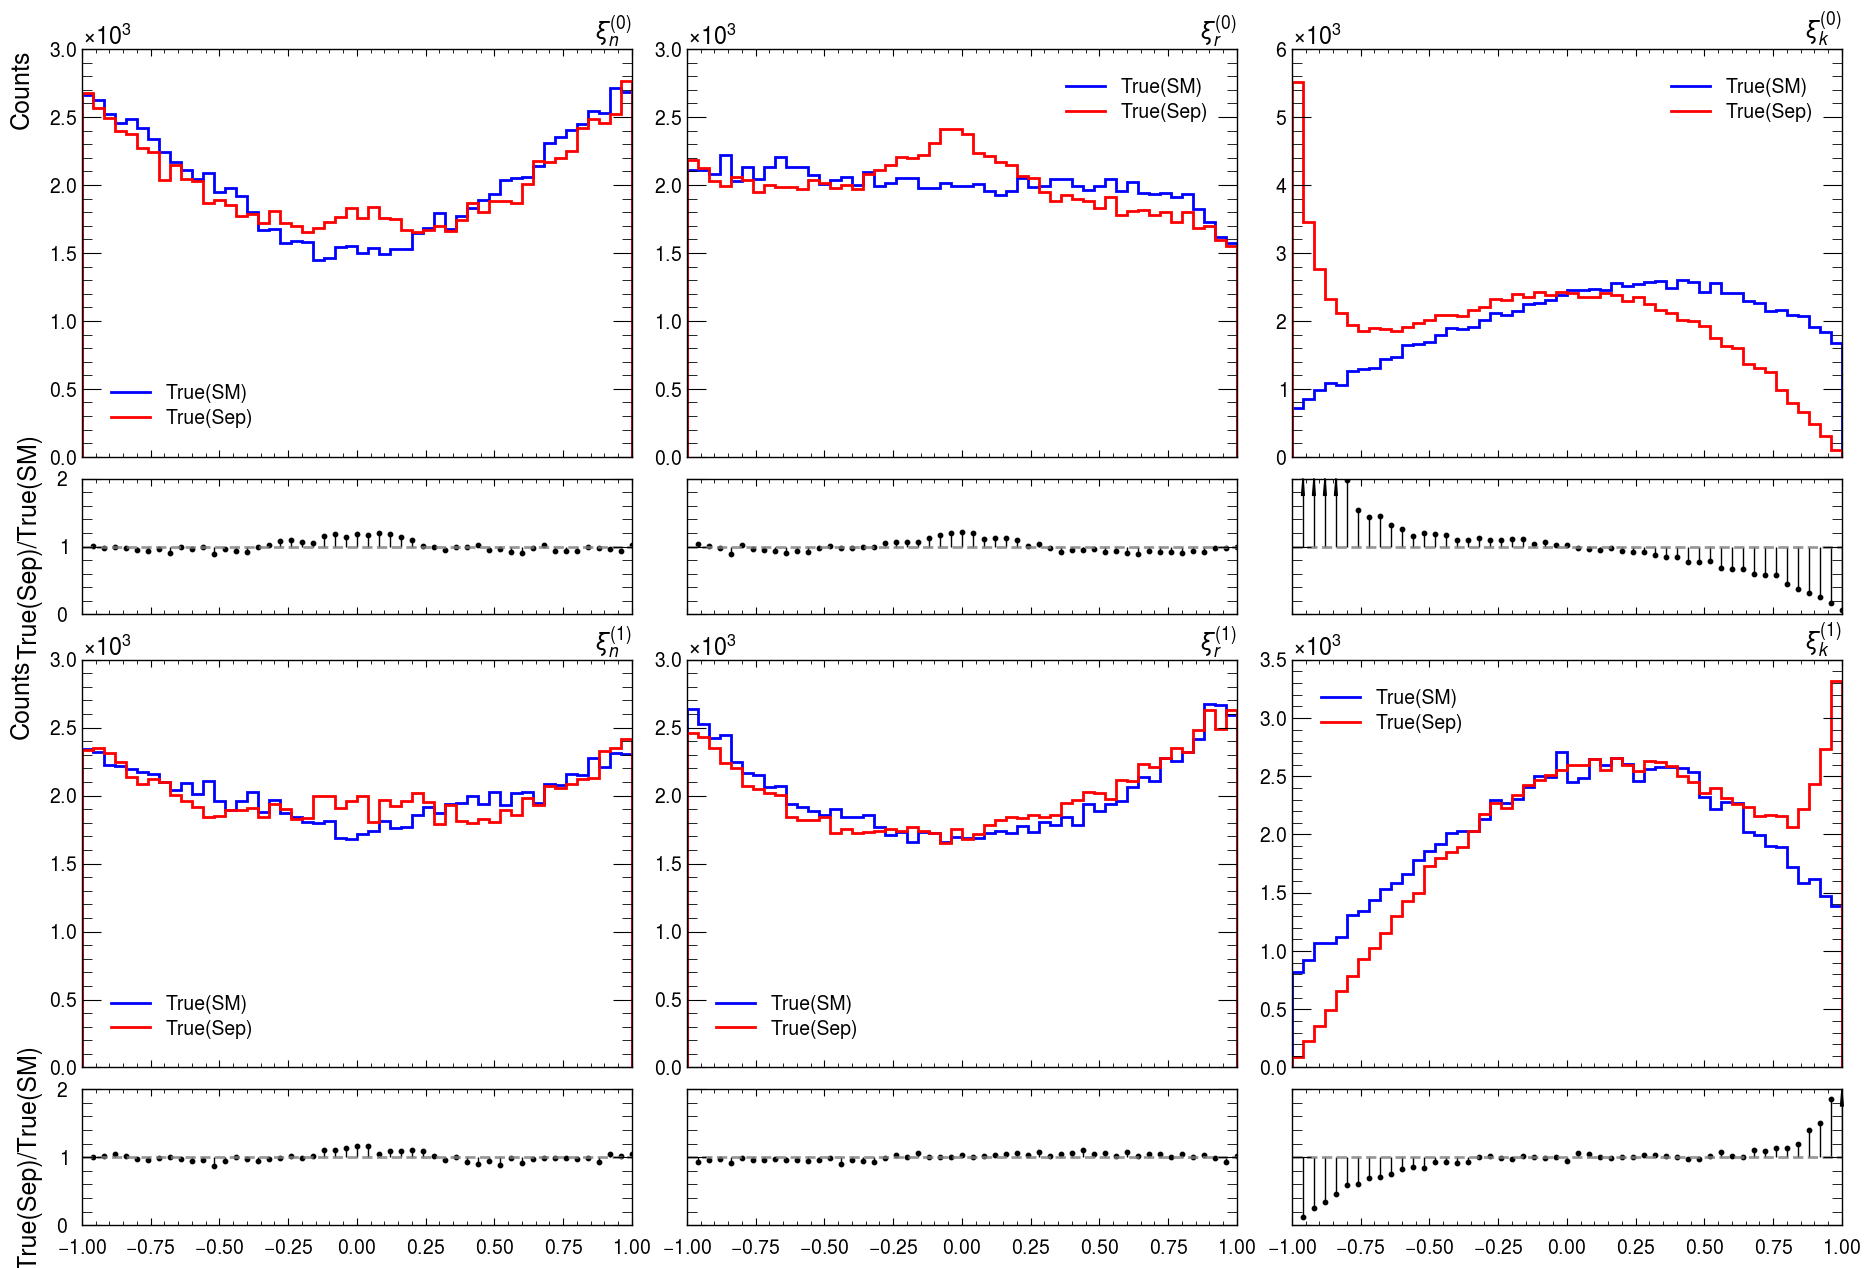

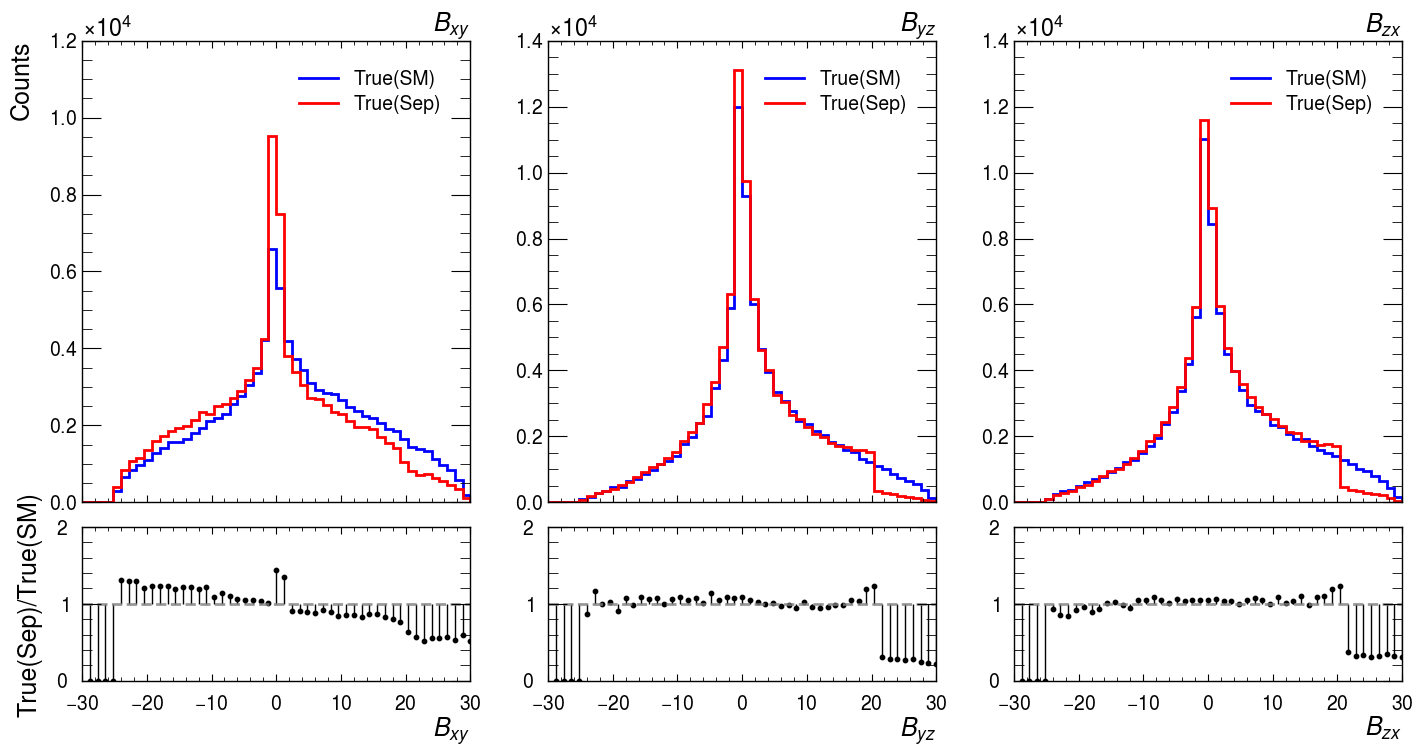


Bxy -> EMD:2.194, kl: 0.626 with SM mean:2.206, Sep mean 0.012
Byz -> EMD:0.979, kl: 0.614 with SM mean:2.494, Sep mean 1.515
Bzx -> EMD:0.821, kl: 0.573 with SM mean:2.772, Sep mean 2.008



In [19]:
# !
"""
Xi comparison:

CAR (ground truth) vs SM (ground truth)
"""

print("CAR (ground truth) vs SM (ground truth)")

# [1] for the first cuts:  fiarness
truth_bij = truth_bij_lst[1][:100_000, ...]
truth_bij_car = car_bij_lst[1][:100_000, ...]
truth_xi_p = truth_xi[1][0][:100_000, ...]
truth_xi_n = truth_xi[1][1][:100_000, ...]
truth_xi_p_car = car_xi[1][0][:100_000, ...]
truth_xi_n_car = car_xi[1][1][:100_000, ...]

# xi
xi_plot_true = [
    truth_xi_p[:, 0],
    truth_xi_p[:, 1],
    truth_xi_p[:, 2],
    truth_xi_n[:, 0],
    truth_xi_n[:, 1],
    truth_xi_n[:, 2],
]
xi_plot_pred = [
    truth_xi_p_car[:, 0],
    truth_xi_p_car[:, 1],
    truth_xi_p_car[:, 2],
    truth_xi_n_car[:, 0],
    truth_xi_n_car[:, 1],
    truth_xi_n_car[:, 2],
]
xi_plot_ranges = [[-1, 1]] * 6
xi_plot_labels = [
    r"$\xi^{(0)}_{n}$",
    r"$\xi^{(0)}_{r}$",
    r"$\xi^{(0)}_{k}$",
    r"$\xi^{(1)}_{n}$",
    r"$\xi^{(1)}_{r}$",
    r"$\xi^{(1)}_{k}$",
]
plot.hist_1d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    legend_lst=["True(Sep)", "True(SM)"],
    ranges=xi_plot_ranges,
    xlabel="",
)

# bij
bij_plot_true = [
    truth_bij[:, 0],
    truth_bij[:, 1],
    truth_bij[:, 2],
]
bij_plot_pred = [
    truth_bij_car[:, 0],
    truth_bij_car[:, 1],
    truth_bij_car[:, 2],
]
bij_plot_ranges = [[-30, 30]] * 3
bij_plot_labels = [
    r"$B_{xy}$",
    r"$B_{yz}$",
    r"$B_{zx}$",
]

plot.hist_1d3plot(
    bij_plot_true,
    bij_plot_pred,
    ranges=bij_plot_ranges,
    xlabel=bij_plot_labels,
    title=bij_plot_labels,
    row1_ylabel="Counts",
    row1_legend=["True(Sep)", "True(SM)"],
    xpad=1,
)

emd = [
    sp.stats.wasserstein_distance(truth_bij[:, i], truth_bij_car[:, i]) for i in range(3)
]

kl_lst = []
for i in range(3):
    # Create histograms
    p, bin_edges = np.histogram(truth_bij[..., i], bins=101, density=True)
    q, _ = np.histogram(truth_bij_car[..., i], bins=bin_edges, density=True)

    # Normalize histograms
    kl = np.sum(sp.special.kl_div(p, q+1e-10))
    kl_lst.append(kl)
    
mean_true = [np.mean(truth_bij[:, i]) for i in range(3)]
mean_car = [np.mean(truth_bij_car[:, i]) for i in range(3)]

print(
    rf"""
Bxy -> EMD:{emd[0]:.3f}, kl: {10*kl_lst[0]:.3f} with SM mean:{mean_true[0]:.3f}, Sep mean {mean_car[0]:.3f}
Byz -> EMD:{emd[1]:.3f}, kl: {10*kl_lst[1]:.3f} with SM mean:{mean_true[1]:.3f}, Sep mean {mean_car[1]:.3f}
Bzx -> EMD:{emd[2]:.3f}, kl: {10*kl_lst[2]:.3f} with SM mean:{mean_true[2]:.3f}, Sep mean {mean_car[2]:.3f}
"""
)

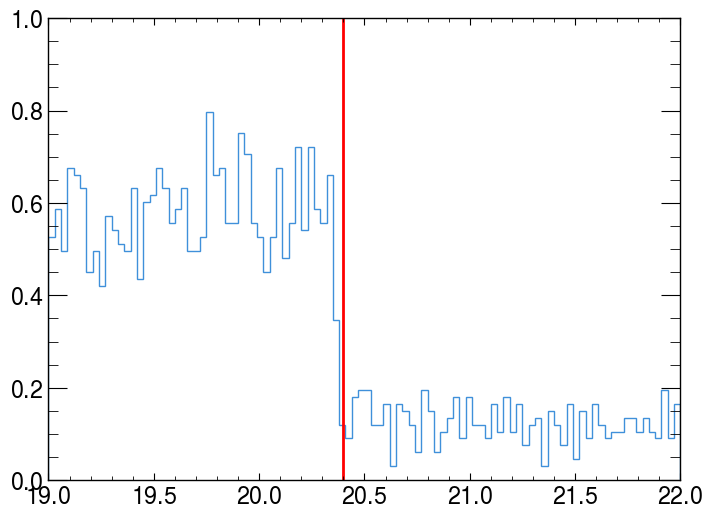

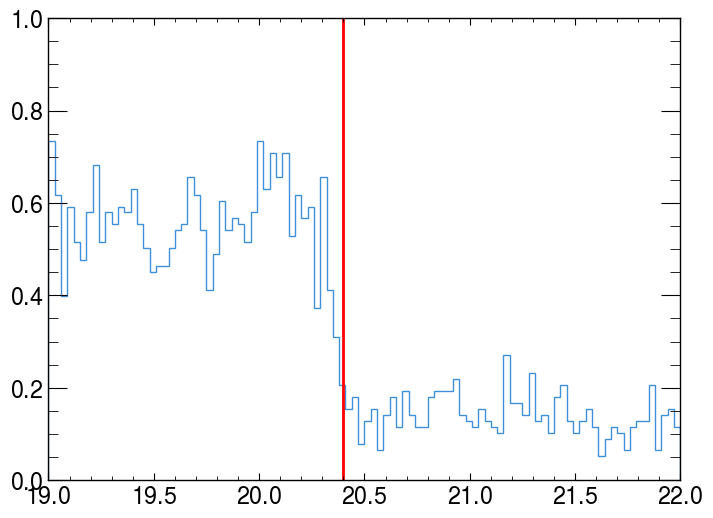

In [20]:
plt.hist(truth_bij_car[:,1], bins=np.linspace(19, 22, 101), histtype="step", label="CAR Bxz", density=True)
plt.vlines(20.4, 0, 1e5, color="r", label="Truth Bxz")
plt.ylim(0, 1)
# plt.semilogx()
plt.show()
plt.hist(truth_bij_car[:,2], bins=np.linspace(19, 22, 101), histtype="step", label="CAR Bxz", density=True)
plt.vlines(20.4, 0, 1e5, color="r", label="Truth Bxz")
plt.ylim(0, 1)
# plt.semilogx()
plt.show()

In [21]:
crack_mask_xz = truth_bij_car[:,1] > 20.4
crack_mask_yz = truth_bij_car[:,2] > 20.4

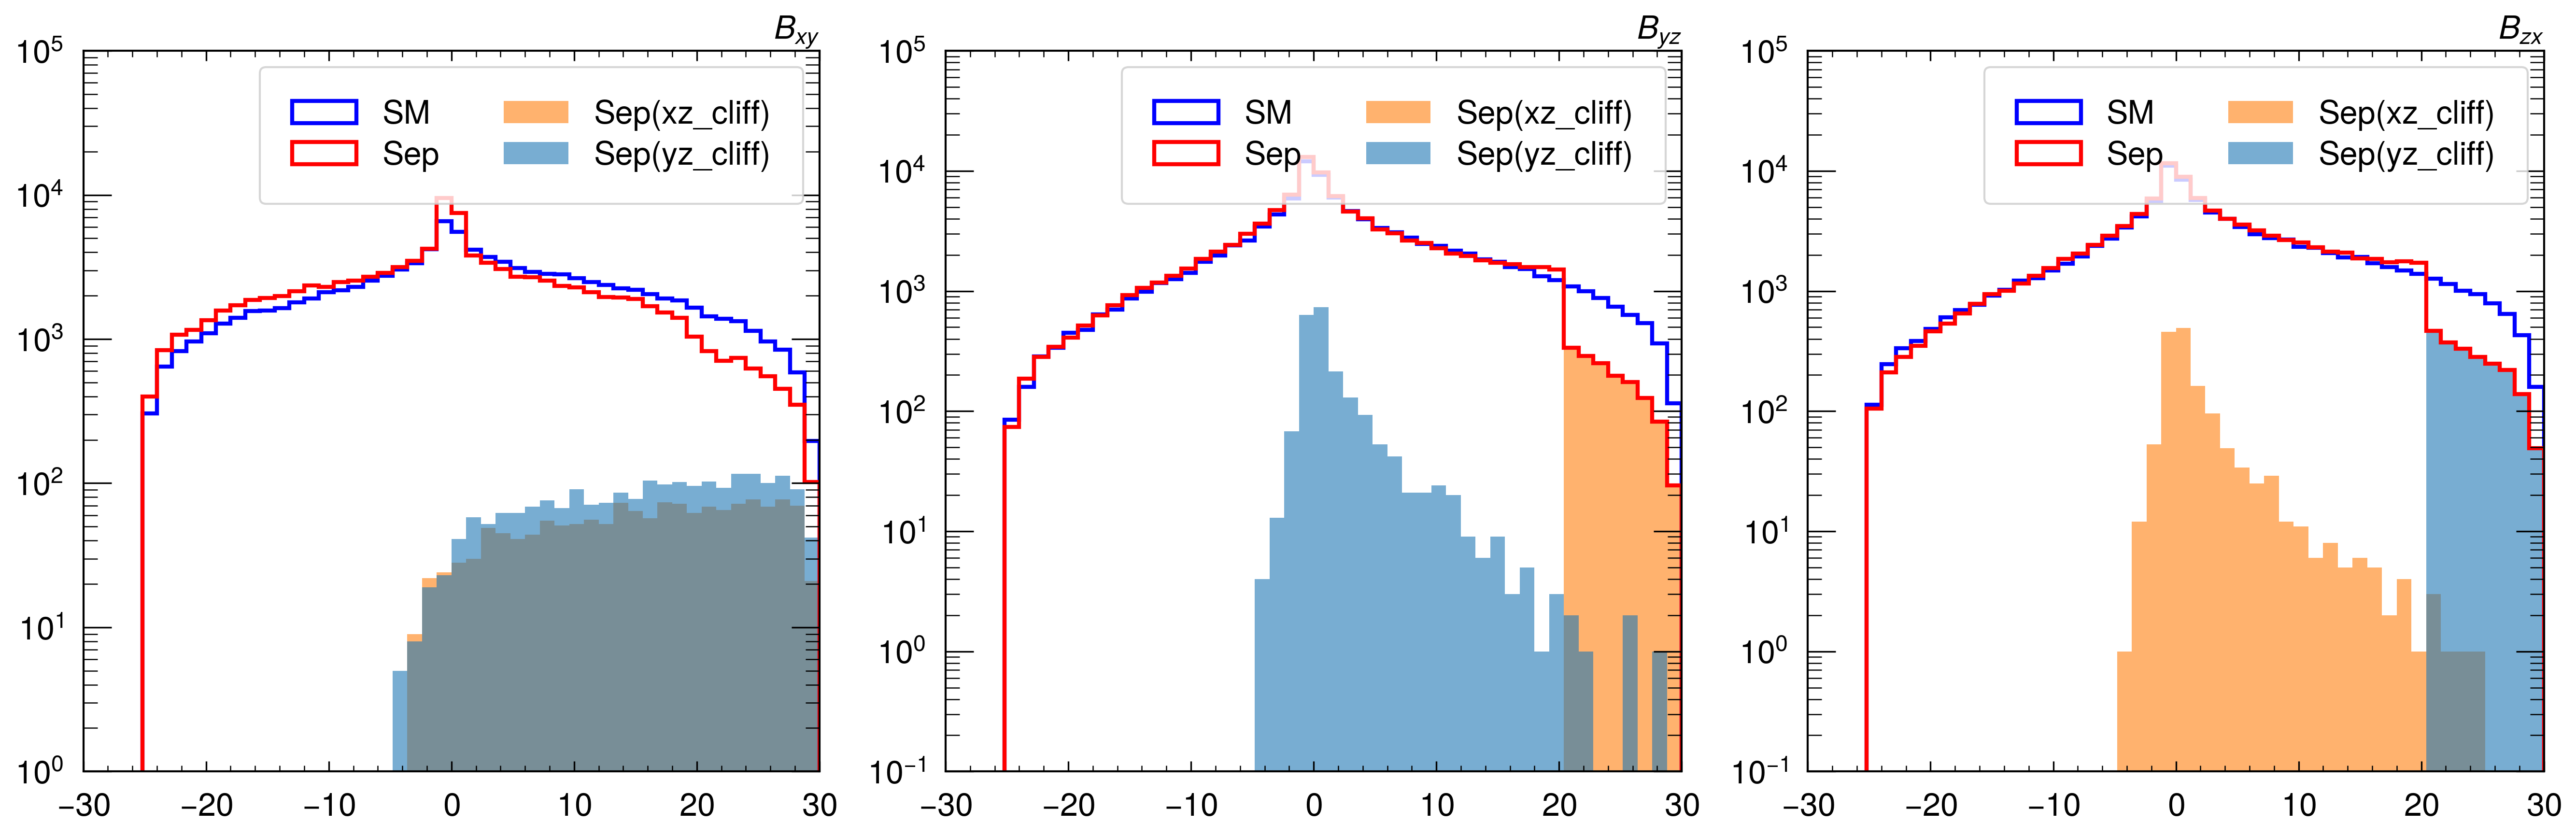

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)  # Create a 1x3 grid of subplots

# Repeat similar code for the 3 subplots
for i in range(3):
    axes[i].hist(
        truth_bij[:, i],
        bins=np.linspace(-30, 30, 51),
        histtype="step",
        label="SM",
        color="blue",
        linewidth=2,
    )
    axes[i].hist(
        truth_bij_car[:, i],
        bins=np.linspace(-30, 30, 51),
        histtype="step",
        label="Sep",
        color="red",
        linewidth=2,
    )
    axes[i].hist(
        truth_bij_car[:, i][crack_mask_xz],
        bins=np.linspace(-30, 30, 51),
        histtype="bar",
        label="Sep(xz_cliff)",
        color="tab:orange",
        alpha=.6,
        linewidth=2,
    )
    axes[i].hist(
        truth_bij_car[:, i][crack_mask_yz],
        bins=np.linspace(-30, 30, 51),
        histtype="bar",
        label="Sep(yz_cliff)",
        color="tab:blue",
        alpha=.6,
        linewidth=2,
    )
    axes[i].legend(ncol=2, frameon=True, loc="upper right", fontsize=16)
    axes[i].tick_params(labelsize=16, pad=10)
    axes[i].semilogy()
    axes[i].set_title(bij_plot_labels[i], fontsize=16, loc="right")

# Adjust layout
plt.tight_layout()
plt.show()

In [23]:
# crack analysis

def cglmp_terms(z_xp, z_xn, z_yp, z_yn):
    """
    This is a function to calculate Bij (CGLMP values).
    :param z_xp: Angle (xi) between positive lepton and x-axis.
    :param z_xn: Angle (xi) between negative lepton and x-axis.
    :param z_yp: Angle (xi) between positive lepton and y-axis.
    :param z_xn: Angle (xi) between negative lepton and y-axis.
    """
    # count expectation value, use (27) in Alan's paper
    tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
    tr_b = (
        25 * (np.square(z_xp) - np.square(z_yp)) * (np.square(z_xn) - np.square(z_yn))
    )
    tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)

    return tr_a, tr_b, tr_c

xy_term1, xy_term2, xy_term3 = cglmp_terms(truth_xi_p[:, 0], truth_xi_n[:, 0], truth_xi_p[:, 1], truth_xi_n[:, 1])
yz_term1, yz_term2, yz_term3 = cglmp_terms(truth_xi_p[:, 1], truth_xi_n[:, 1], truth_xi_p[:, 2], truth_xi_n[:, 2])
zx_term1, zx_term2, zx_term3 = cglmp_terms(truth_xi_p[:, 2], truth_xi_n[:, 2], truth_xi_p[:, 0], truth_xi_n[:, 0])

xy_term1_car, xy_term2_car, xy_term3_car = cglmp_terms(truth_xi_p_car[:, 0], truth_xi_n_car[:, 0], truth_xi_p_car[:, 1], truth_xi_n_car[:, 1])
yz_term1_car, yz_term2_car, yz_term3_car = cglmp_terms(truth_xi_p_car[:, 1], truth_xi_n_car[:, 1], truth_xi_p_car[:, 2], truth_xi_n_car[:, 2])
zx_term1_car, zx_term2_car, zx_term3_car = cglmp_terms(truth_xi_p_car[:, 2], truth_xi_n_car[:, 2], truth_xi_p_car[:, 0], truth_xi_n_car[:, 0])

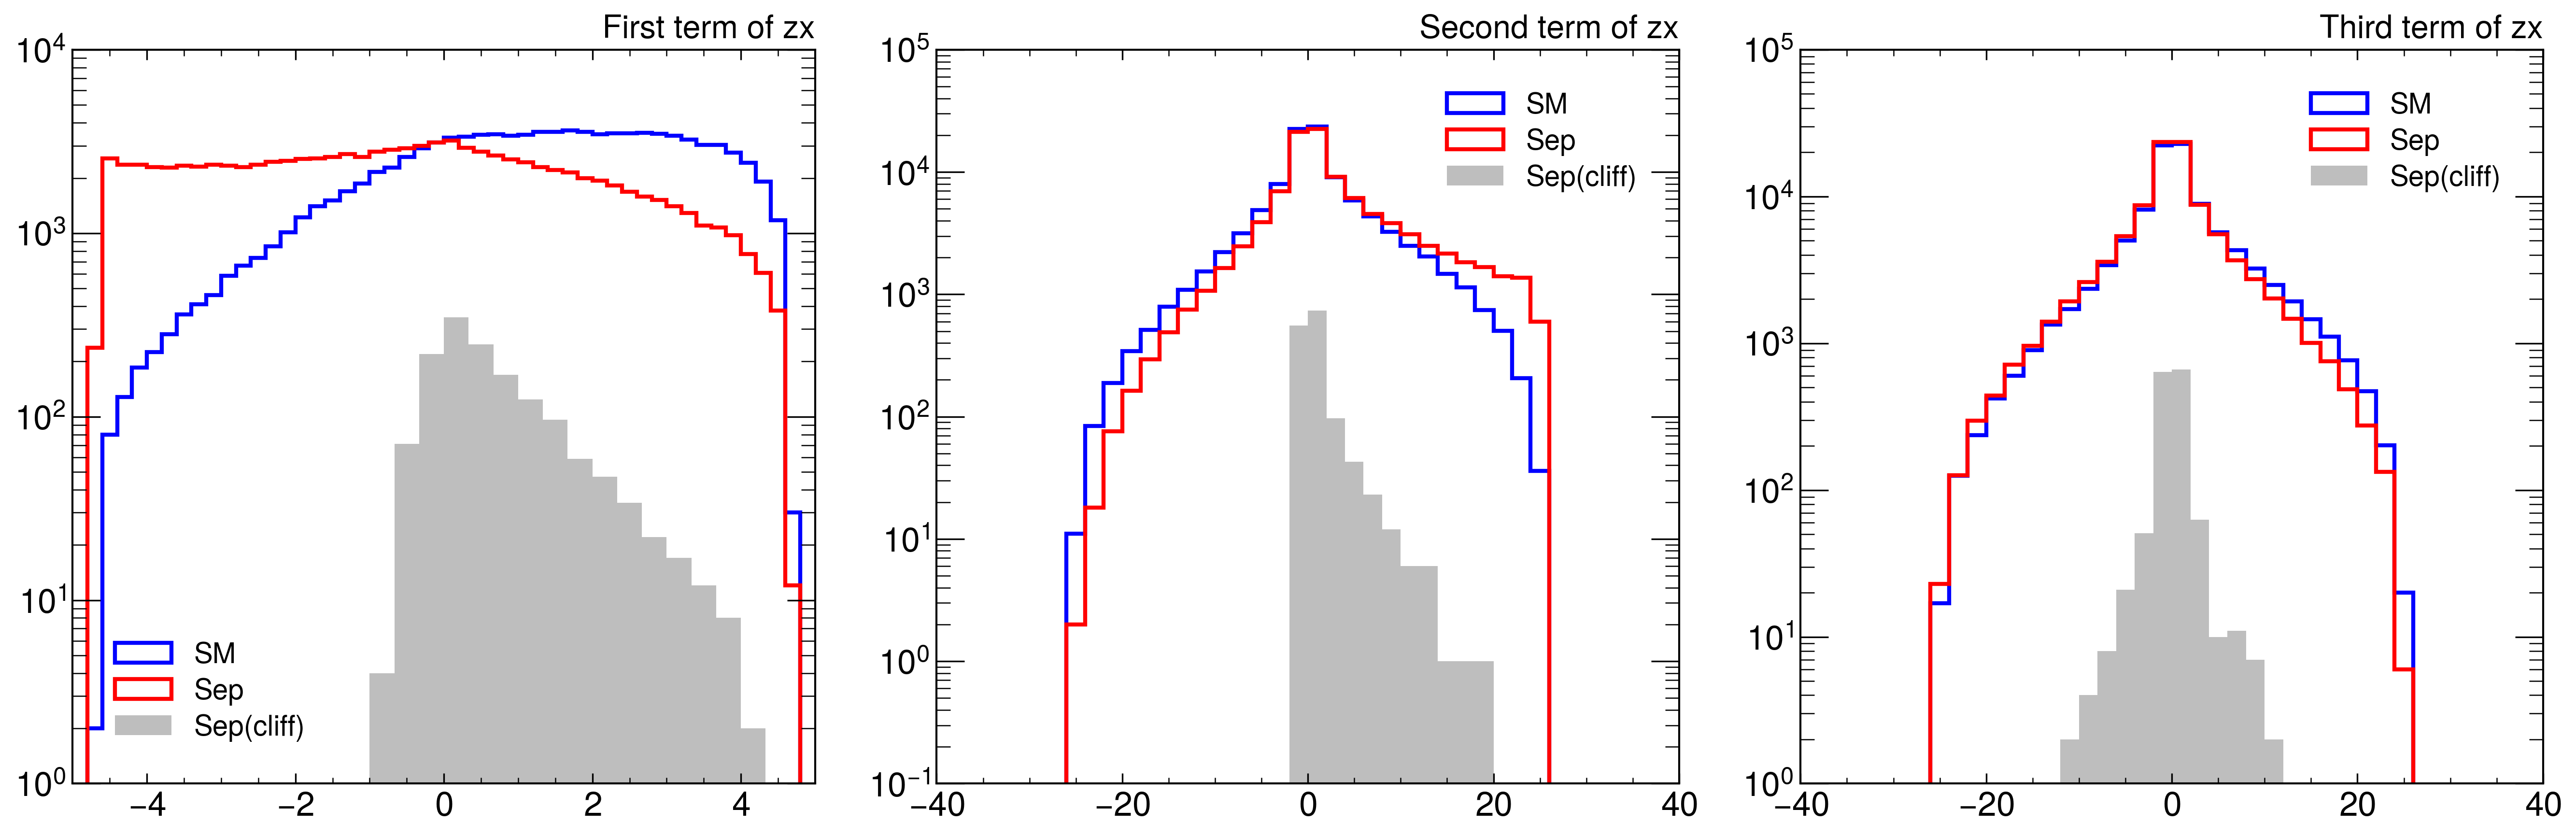

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)

# First term
axes[0].hist(
    zx_term1,
    bins=np.linspace(-5, 5, 51),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[0].hist(
    zx_term1_car,
    bins=np.linspace(-5, 5, 51),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[0].hist(
    zx_term1_car[crack_mask_xz],
    bins=np.linspace(-5, 5, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[0].legend()
axes[0].semilogy()
axes[0].set_title("First term of zx", fontsize=16, loc="right")

# Second term
axes[1].hist(
    zx_term2,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[1].hist(
    zx_term2_car,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[1].hist(
    zx_term2_car[crack_mask_xz],
    bins=np.linspace(-30, 30, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[1].legend()
axes[1].semilogy()
axes[1].set_title("Second term of zx", fontsize=16, loc="right")

# Third term
axes[2].hist(
    zx_term3,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[2].hist(
    zx_term3_car,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[2].hist(
    zx_term3_car[crack_mask_xz],
    bins=np.linspace(-30, 30, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[2].legend()
axes[2].semilogy()
axes[2].set_title("Third term of zx", fontsize=16, loc="right")

plt.tight_layout()
plt.show()

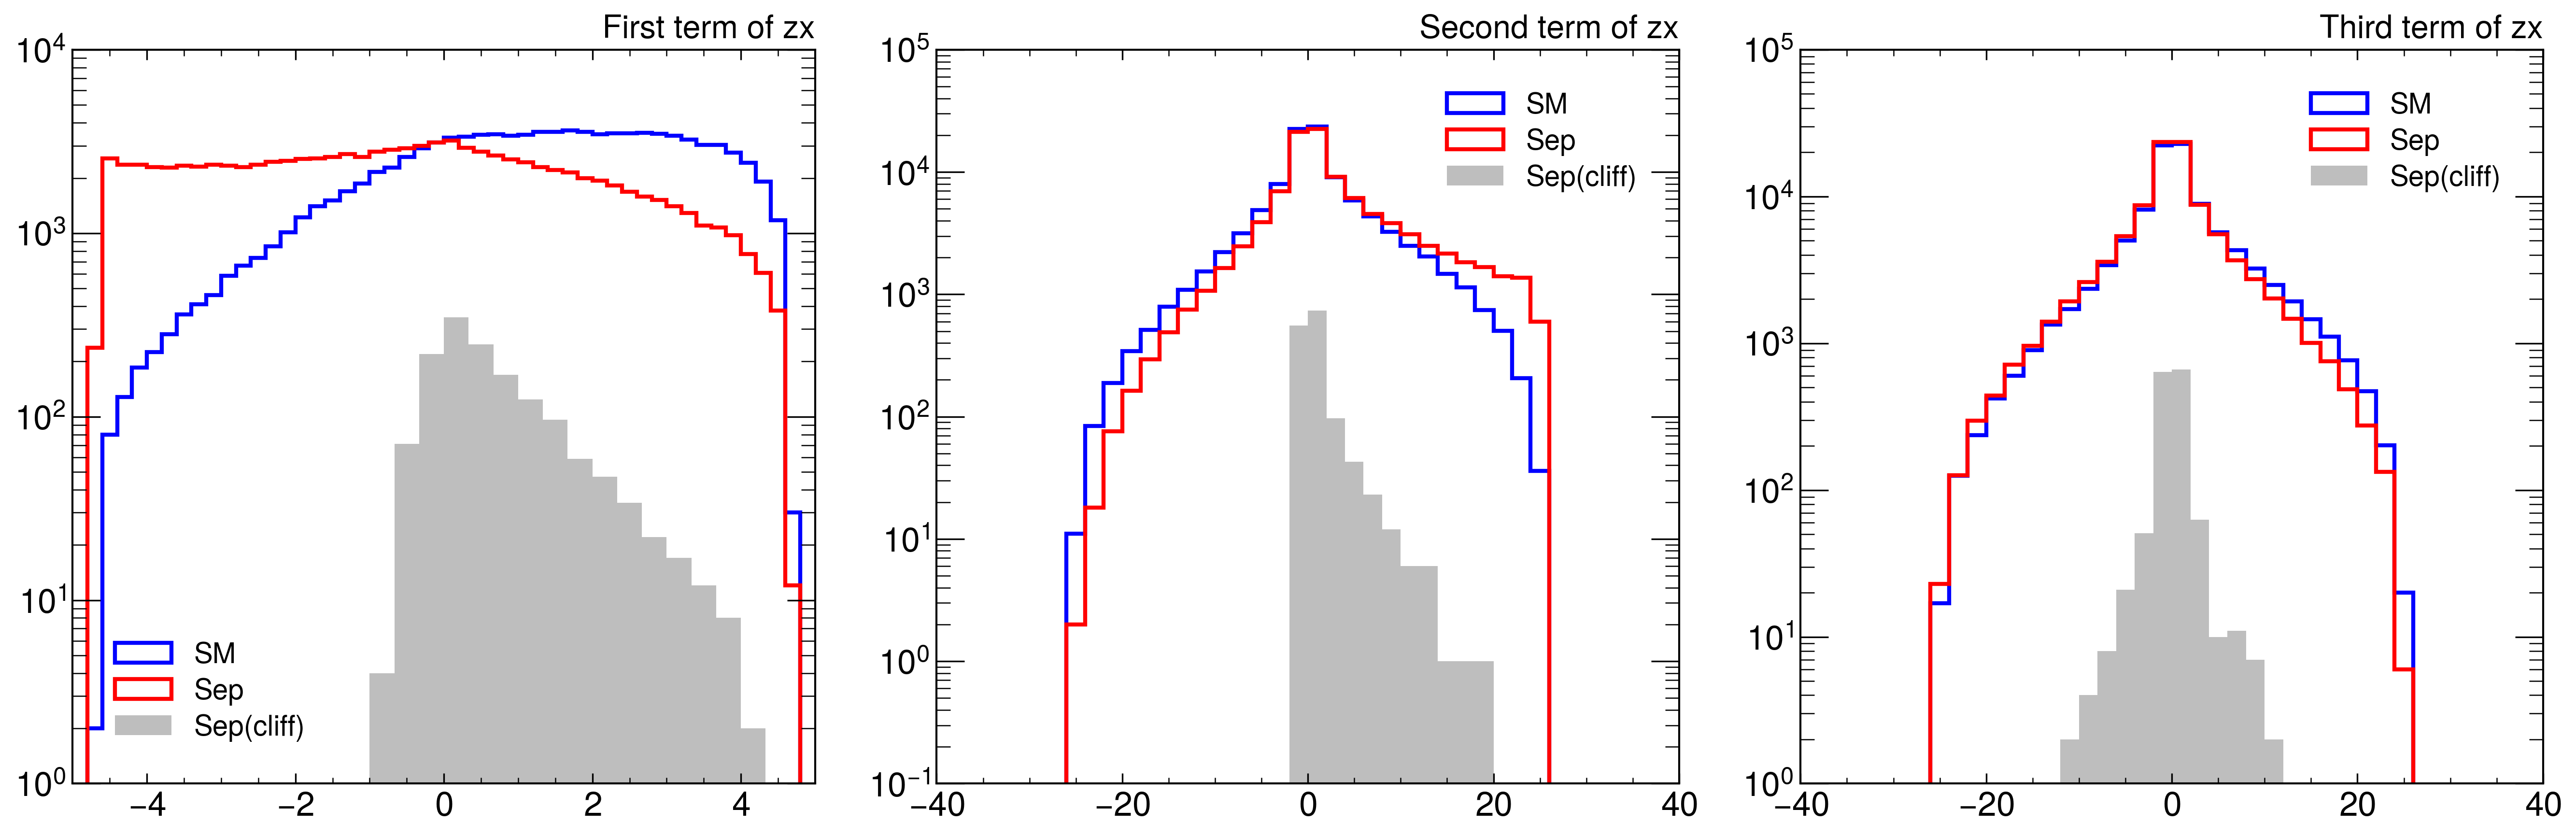

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)

# First term
axes[0].hist(
    zx_term1,
    bins=np.linspace(-5, 5, 51),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[0].hist(
    zx_term1_car,
    bins=np.linspace(-5, 5, 51),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[0].hist(
    zx_term1_car[crack_mask_xz],
    bins=np.linspace(-5, 5, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[0].legend()
axes[0].semilogy()
axes[0].set_title("First term of zx", fontsize=16, loc="right")

# Second term
axes[1].hist(
    zx_term2,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[1].hist(
    zx_term2_car,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[1].hist(
    zx_term2_car[crack_mask_xz],
    bins=np.linspace(-30, 30, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[1].legend()
axes[1].semilogy()
axes[1].set_title("Second term of zx", fontsize=16, loc="right")

# Third term
axes[2].hist(
    zx_term3,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[2].hist(
    zx_term3_car,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[2].hist(
    zx_term3_car[crack_mask_xz],
    bins=np.linspace(-30, 30, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[2].legend()
axes[2].semilogy()
axes[2].set_title("Third term of zx", fontsize=16, loc="right")

plt.tight_layout()
plt.show()

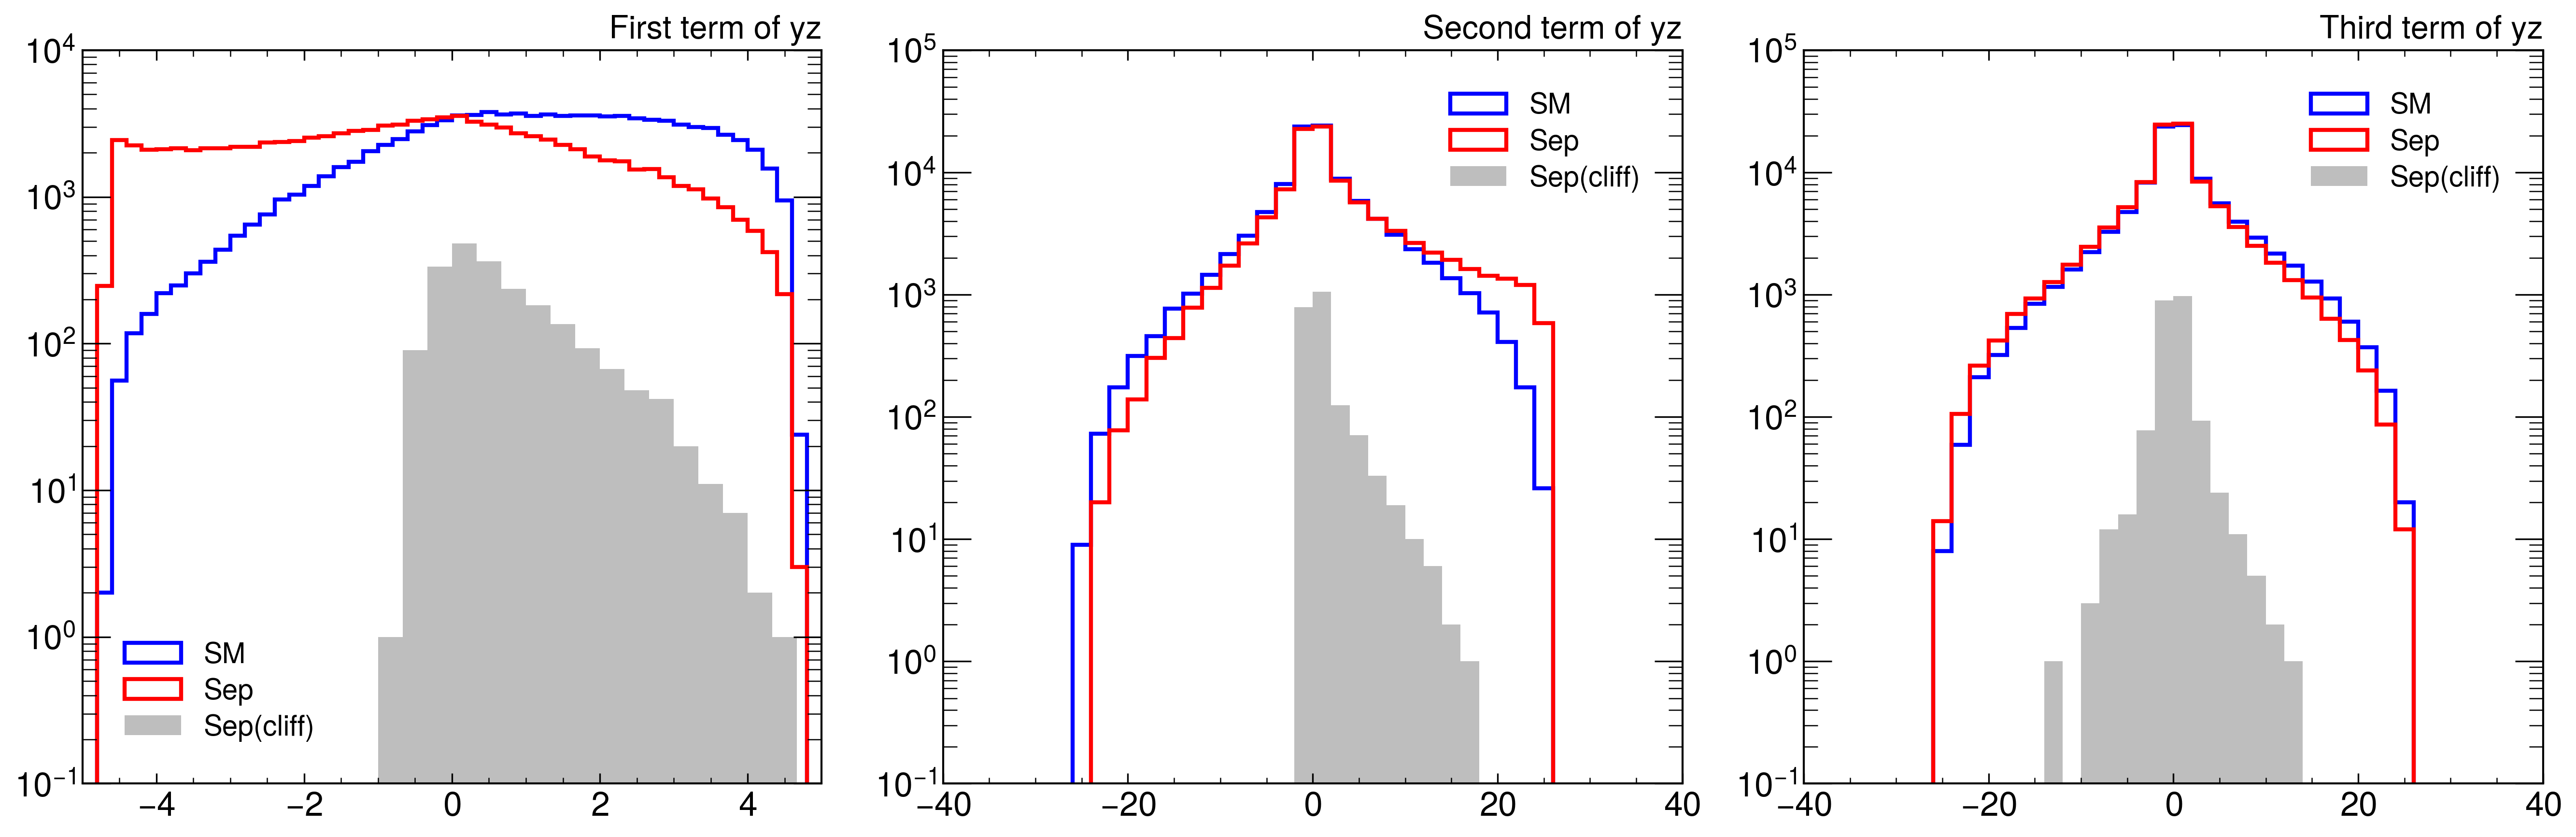

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)

# First term
axes[0].hist(
    yz_term1,
    bins=np.linspace(-5, 5, 51),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[0].hist(
    yz_term1_car,
    bins=np.linspace(-5, 5, 51),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[0].hist(
    yz_term1_car[crack_mask_yz],
    bins=np.linspace(-5, 5, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[0].legend()
axes[0].semilogy()
axes[0].set_title("First term of yz", fontsize=16, loc="right")

# Second term
axes[1].hist(
    yz_term2,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[1].hist(
    yz_term2_car,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[1].hist(
    yz_term2_car[crack_mask_yz],
    bins=np.linspace(-30, 30, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[1].legend()
axes[1].semilogy()
axes[1].set_title("Second term of yz", fontsize=16, loc="right")

# Third term
axes[2].hist(
    yz_term3,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="SM",
    color="blue",
    linewidth=2,
)
axes[2].hist(
    yz_term3_car,
    bins=np.linspace(-30, 30, 31),
    histtype="step",
    label="Sep",
    color="red",
    linewidth=2,
)
axes[2].hist(
    yz_term3_car[crack_mask_yz],
    bins=np.linspace(-30, 30, 31),
    histtype="bar",
    label="Sep(cliff)",
    color="tab:grey",
    alpha=0.5,
    linewidth=2,
)
axes[2].legend()
axes[2].semilogy()
axes[2].set_title("Third term of yz", fontsize=16, loc="right")

plt.tight_layout()
plt.show()